## Figure 4 Code to Produce Figures

This figure will focus on the presentation of Further Analysis of Extracted Assemblies.

In [6]:
# Breadcumb: I have loaded assembly traces, and written a function to compare.  Now load random ensembles, and pass their traces and the assembly ones to the function.

# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import squareform, pdist
import scipy.io
from scipy import stats
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from difflib import diff_bytes
import seaborn as sns
import h5py
import scipy
import os
plt.rcParams.update({'font.size': 18})
plt.rcParams["figure.figsize"] = (10,10)

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Oracle Scores Assemblies

In [8]:
### Functions relevant for Oracle Score Analysis

def distance(x, y):
    return math.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)

# def process(img):
#     img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img_canny = cv2.Canny(img_gray, 0, 50)
#     img_dilate = cv2.dilate(img_canny, None, iterations=1)
#     img_erode = cv2.erode(img_dilate, None, iterations=1)
#     return img_erode

def correlate_assembly_traces_vs_random_ensembles(assembly_traces, random_ensemble_traces, scores_in_order, name='compared_time_traces'):
    # Set up three subplots
    num_assemblies = assembly_traces.shape[1]
    # fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    # for i in range(num_assemblies):
    #     ax[i].plot(assembly_traces[:, i], color='green', label='Assembly')
    #     ax[i].plot(random_ensemble_traces[:, i], color='red', label='Random Ensemble')
    #     ax[i].set_ylabel(f"{scores_in_order[i]:.2}")
    #     ax[i].set_xlabel("Time Steps")
    #     ax[i].grid()
    #     ax[i].legend()

    fig.suptitle("Assembly Time Trace vs Random Ensemble Time Trace")
    # Calculate mean r score between all pairs of assemblies
    assembly_r_scores = []
    for i in range(num_assemblies):
        for j in range(num_assemblies):
            if i != j:
                assembly_r_scores.append(stats.pearsonr(assembly_traces[:, i], assembly_traces[:, j])[0]**2)
    print(f"Mean R^2 Score: {np.mean(assembly_r_scores)}")
    # Cacuate mean r score between all pairs of random ensembles
    null_r_scores = []
    for i in range(num_assemblies):
        for j in range(num_assemblies):
            if i != j:
                null_r_scores.append(stats.pearsonr(random_ensemble_traces[:, i], random_ensemble_traces[:, j])[0])
        # print(stats.pearsonr(random_ensemble_traces[:, i], random_ensemble_traces[:, i])[0])
        # print()
        # null_r_scores.append(stats.pearsonr(random_ensemble_traces[:, i], random_ensemble_traces[:, j])[0])
    print(f"Mean R^2 Score Random Ensemble: {np.mean(null_r_scores)}")
    #perform a wicoxen ranksum test on the two sets of r scores
    print(stats.ranksums(assembly_r_scores, null_r_scores))
    print(stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten(), alternative = 'less').pvalue)

    #plt

    plt.figure(figsize=(14, 10))    
    all_arr = [np.array(assembly_r_scores).flatten(),
                np.array(null_r_scores).flatten()]
    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(data=all_arr,
                    notch=True, showcaps=True,
                    flierprops={"marker": "x"},
                    boxprops={"facecolor": (.4, .6, .8, .5)},
                    medianprops={"color": "coral"},
                )
    ax.set_xticklabels(["Assemblies", "Random Ensembles"], size = 16)
    ax.set_title('Correlation of Assemblies and Random Ensembles', size = 20)
    ax.set_ylabel('Correlation (R)', size = 18)
    plt.yticks(fontsize=16)

    medians = np.array(
        [np.median(np.array(assembly_r_scores).flatten()),
        np.median(np.array(null_r_scores).flatten())]
    )

    vertical_offset = medians * 0.02 # offset from median for display
    p_values = [np.nan,
                'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_r_scores).flatten(), np.array(null_r_scores).flatten(), alternative = 'less').pvalue, 5)]

    for xtick in ax.get_xticks():
        if xtick != 0:
            ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                    horizontalalignment='center', size= 12, color='black', weight='semibold')

    plt.savefig('assemblies_vs_random_ensembles_boxplot.png', dpi = 1200)
    plt.show()

def get_assembly_time_trace(coactivity_trace, scores_in_order, name='scored_time_trace'):
    # Set up three subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color='green')
        ax[i].set_ylabel(f"{scores_in_order[i]:.2}")
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle("Assembly Time Trace")
    #plt.savefig(f"oracle_dists2/assemblies_esteps_150000_affinity_04_{name}.png", dpi = 1200)

In [9]:
ACTIVITY_RASTER = scipy.io.loadmat(
    "data_files/v1dd/functional/final/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat", struct_as_record=True, squeeze_me=True)
SGC_ASSEMBLIES = scipy.io.loadmat(
    "data_files/v1dd/functional/final/esteps_150000_affinity_04_sessionM409828_13_SGC-ASSEMBLIES.mat", struct_as_record=True, squeeze_me=True)

#print(ACTIVITY_RASTER.keys())

activity_raster = ACTIVITY_RASTER['activity_raster']
activity_raster_peaks = ACTIVITY_RASTER['activity_raster_peaks']

coactivity_trace = activity_raster.mean(axis=1)
 
assemblies = SGC_ASSEMBLIES['assemblies']
#print(assemblies)
assembly_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in assemblies]).T

scores_in_order = np.load('old_misc/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_assembly_time_trace(assembly_coactivity_trace, scores_in_order)

FileNotFoundError: [Errno 2] No such file or directory: 'data_files/v1dd/functional/final/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat'

In [1]:
nwb_f = h5py.File('M409828_13_20181213.nwb', 'r')
import v1dd_physiology.data_fetching as daf

sess_id = daf.get_session_id(nwb_f=nwb_f)
print(sess_id)

# plane_ns = daf.get_plane_names(nwb_f=nwb_f)
# print("Planes: ", plane_ns)

# for plane_n in plane_ns:
#     depth = daf.get_plane_depth(nwb_f=nwb_f, plane_n=plane_n)
#     print(f'depth of {plane_n}: {depth} um')

fs = []
dffs = []
events = []
locomotions = []
rois = []
pika_rois = []
coords = []

# Uncomment this if you want the actual fluorescence activity trace
# f = np.array(nwb_f['processing']['rois_and_traces_plane0']
#              ['Fluorescence']['f_raw_subtracted'].get('data'))

# If you want DFF, you need to compute it using the allensdk, or load saved traces from /home/berteau/v1DD

f = assembly_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
# events
clip_ts = f.shape[1]

total_movie_oracle_r_values = np.zeros((0, 9))

passing_roi_count = f.shape[1]

oracle_r_values = np.zeros((passing_roi_count, 25, 8))
movie_oracle_r_values = np.zeros((passing_roi_count, 9))

NameError: name 'h5py' is not defined

In [6]:
plane_ns = daf.get_plane_names(nwb_f=nwb_f)
plane_ns
rois_dict = {}
for plane_n in plane_ns:
    roi_ns = daf.get_roi_ns(nwb_f=nwb_f, plane_n=plane_n)
    print(f'there are {len(roi_ns)} in {plane_n} of session: {sess_id}:')
    print('\nnames of first 100 rois:\n')
    print(roi_ns[0:100])
    rois_dict[plane_n] = roi_ns

there are 1234 in plane0 of session: M409828_13:

names of first 100 rois:

['roi_0000', 'roi_0001', 'roi_0002', 'roi_0003', 'roi_0004', 'roi_0005', 'roi_0006', 'roi_0007', 'roi_0008', 'roi_0009', 'roi_0010', 'roi_0011', 'roi_0012', 'roi_0013', 'roi_0014', 'roi_0015', 'roi_0016', 'roi_0017', 'roi_0018', 'roi_0019', 'roi_0020', 'roi_0021', 'roi_0022', 'roi_0023', 'roi_0024', 'roi_0025', 'roi_0026', 'roi_0027', 'roi_0028', 'roi_0029', 'roi_0030', 'roi_0031', 'roi_0032', 'roi_0033', 'roi_0034', 'roi_0035', 'roi_0036', 'roi_0037', 'roi_0038', 'roi_0039', 'roi_0040', 'roi_0041', 'roi_0042', 'roi_0043', 'roi_0044', 'roi_0045', 'roi_0046', 'roi_0047', 'roi_0048', 'roi_0049', 'roi_0050', 'roi_0051', 'roi_0052', 'roi_0053', 'roi_0054', 'roi_0055', 'roi_0056', 'roi_0057', 'roi_0058', 'roi_0059', 'roi_0060', 'roi_0061', 'roi_0062', 'roi_0063', 'roi_0064', 'roi_0065', 'roi_0066', 'roi_0067', 'roi_0068', 'roi_0069', 'roi_0070', 'roi_0071', 'roi_0072', 'roi_0073', 'roi_0074', 'roi_0075', 'roi_0076',

In [7]:
assembly_neurons = set()
for assembly in assemblies:
    assembly_neurons.update(set(assembly))
assembly_neurons = np.array(list(assembly_neurons))
len(assembly_neurons)

1960

In [8]:
# pika_rois_all_dict = {}
# pika_rois_in_assembly_dict = {}
# pika_rois_no_assembly_dict = {}
# for plane_n, roi_ns in rois_dict.items():
#     pika_rois = []
#     pika_rois_in_assembly = []
#     pika_rois_no_assembly = []
#     # print(plane_n)
#     for roi_n in roi_ns:
#         score = daf.get_pika_classifier_score(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n)
#         if score > 0.5:  # Using the threshold from team PIKA, per https://github.com/zhuangjun1981/v1dd_physiology/blob/main/v1dd_physiology/example_notebooks/2022-06-27-data-fetching-basic.ipynb
#             pika_rois.append(roi_n)
#             if int(roi_n[4:]) in assembly_neurons:
#                 pika_rois_in_assembly.append(roi_n)
#             else:
#                 pika_rois_no_assembly.append(roi_n)
#     pika_rois_all_dict[plane_n] = pika_rois
#     pika_rois_in_assembly_dict[plane_n] = pika_rois_in_assembly
#     pika_rois_no_assembly_dict[plane_n] = pika_rois_no_assembly

# total_rois = np.sum([len(val) for val in pika_rois_all_dict.values()])
# neuron_all_movie_oracle_r_values = np.zeros((total_rois, 9))

# total_rois = np.sum([len(val) for val in pika_rois_in_assembly_dict.values()])
# neuron_in_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

# total_rois = np.sum([len(val) for val in pika_rois_no_assembly_dict.values()])
# neuron_no_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

# count_n_all = -1
# count_n_in_assembly = -1
# count_n_no_assembly = -1
# for curr_dict, oracle_array, c in zip([pika_rois_all_dict, pika_rois_in_assembly_dict, pika_rois_no_assembly_dict], 
#         [neuron_all_movie_oracle_r_values, neuron_in_assembly_movie_oracle_r_values, neuron_no_assembly_movie_oracle_r_values],
#         [1,2,3]):
#     for plane_n, pika_roi_ns in curr_dict.items():
#         for roi_n in pika_roi_ns:
#             if c == 1:
#                 count_n_all += 1
#                 current_count = count_n_all
#             elif c == 2:
#                 count_n_in_assembly += 1
#                 current_count = count_n_in_assembly
#             elif c == 3:
#                 count_n_no_assembly += 1
#                 current_count = count_n_no_assembly
#             ### Get Time Trace
#             f, f_ts = daf.get_single_trace(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n, trace_type='subtracted')

#             # Get Repeated Natural Movies
#             trial_fluorescence = []
#             presentation = nwb_f['stimulus']['presentation']
#             nm_timestamps = np.array(
#                 presentation['natural_movie'].get('timestamps'))
#             nm_data = np.array(presentation['natural_movie'].get('data'))
#             new_clips = np.where(nm_data[:, 2] == 0)[0]
#             clip_duration = 300  # new_clips[1]-1
#             for repeat_id in range(new_clips.shape[0]):
#                 frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
#                     0][0:clip_duration]
#                 trial_fluorescence.append(f[frames_to_capture])
#             trial_fluorescence_np = np.array(trial_fluorescence)
#             for trial_idx in range(trial_fluorescence_np.shape[0]):
#                 removed_trial = trial_fluorescence_np[trial_idx]
#                 remaining_trials = np.delete(
#                     trial_fluorescence_np, trial_idx, 0)
#                 r, p = scipy.stats.pearsonr(
#                     removed_trial, np.mean(remaining_trials, 0))
#                 oracle_array[current_count, trial_idx] = r

# groups_p_values = ['T-test: {:.3g}'.format(stats.ttest_ind(np.array(neuron_all_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), equal_var = False).pvalue, 5),
#                     'T-test: {:.3g}'.format(stats.ttest_ind(np.array(neuron_all_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), equal_var = False).pvalue, 5)]


# all_arr = [np.array(neuron_all_movie_oracle_r_values).flatten(),
#             np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
#             np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(data=all_arr)
# ax.set_xticklabels(["All Neurons", "Neurons In Assembly", "Neurons Out Assembly"], size = 16)
# ax.set_title('Natural Movie Oracle Score', size = 22)
# ax.set_ylabel('Oracle Score', size = 16)

# print(groups_p_values)

In [9]:
# movie_oracle_r_values = np.zeros((passing_roi_count, 9))
# f = assembly_coactivity_trace
# # print(coactivity_trace)
# f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
#                 ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
# for roi_n in range(passing_roi_count):

#     # Get Repeated Natural Movies
#     trial_fluorescence = []
#     presentation = nwb_f['stimulus']['presentation']
#     nm_timestamps = np.array(
#         presentation['natural_movie'].get('timestamps'))
#     nm_data = np.array(presentation['natural_movie'].get('data'))
#     new_clips = np.where(nm_data[:, 2] == 0)[0]
#     clip_duration = 300  # new_clips[1]-1
#     for repeat_id in range(new_clips.shape[0]):
#         frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
#             0][0:clip_duration]
#         trial_fluorescence.append(f[frames_to_capture, roi_n])
#     trial_fluorescence_np = np.array(trial_fluorescence)
#     for trial_idx in range(trial_fluorescence_np.shape[0]):
#         removed_trial = trial_fluorescence_np[trial_idx]
#         remaining_trials = np.delete(
#             trial_fluorescence_np, trial_idx, 0)
#         r, p = scipy.stats.pearsonr(
#             removed_trial, np.mean(remaining_trials, 0))
#         movie_oracle_r_values[roi_n, trial_idx] = r

#     # get_assembly_time_trace(trial_fluorescence_np.T, movie_oracle_r_values[roi_n, :], name=f'r_value_over_each_natural_movie_assembly{roi_n}')

#     # total_movie_oracle_r_values = np.append(
#     #     total_movie_oracle_r_values, movie_oracle_r_values, 0)
# # Plot Movie Oracles
# mean_over_holdouts = np.mean(movie_oracle_r_values, 1)
# fig = plt.figure()
# plt.title('Assembly natural movie oracle score')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.hist(mean_over_holdouts[:], bins=50)
# #plt.savefig('oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
# plt.show()


# all_arr = [np.array(movie_oracle_r_values).flatten(),
#             np.array(neuron_all_movie_oracle_r_values).flatten(),
#             np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
#             np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]

# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(data=all_arr,
#                 notch=True, showcaps=True,
#                 flierprops={"marker": "x"},
#                 boxprops={"facecolor": (.4, .6, .8, .5)},
#                 medianprops={"color": "coral"},
#             )
# ax.set_xticklabels(["Assemblies", "All Neurons", "Neurons In Assembly", "Neurons Out Assembly"], size = 12)
# ax.set_title('Natural Movie Oracle Score', size = 20)
# ax.set_ylabel('Oracle Score', size = 14)

# medians = np.array(
#     [np.median(np.array(movie_oracle_r_values).flatten()),
#      np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
#      np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
#      np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
# )

# vertical_offset = medians * 0.2 # offset from median for display
# p_values = [np.nan,
#             'T-test: {:.3g}'.format(stats.ttest_ind(np.array(movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), equal_var = False).pvalue, 5),
#             'T-test: {:.3g}'.format(stats.ttest_ind(np.array(movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), equal_var = False).pvalue, 5),
#             'T-test: {:.3g}'.format(stats.ttest_ind(np.array(movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), equal_var = False).pvalue, 5)]

# for xtick in ax.get_xticks():
#     if xtick != 0:
#         ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
#                 horizontalalignment='center', size='small', color='black', weight='semibold')

# #plt.savefig('oracle_scores_histogram_f_subtracted.png', dpi = 1200)
# plt.show()

# # plt.close()
# # np.save('oracle_dists2/assemblies_esteps_150000_affinity_04_session'+str(13)+
# #         '_natural_movie_oracle_r_values.npy', movie_oracle_r_values)
# # np.save('oracle_dists2/assemblies_esteps_150000_affinity_04_session'+str(13)+
# #         '_natural_movie_oracle_scores.npy', mean_over_holdouts)

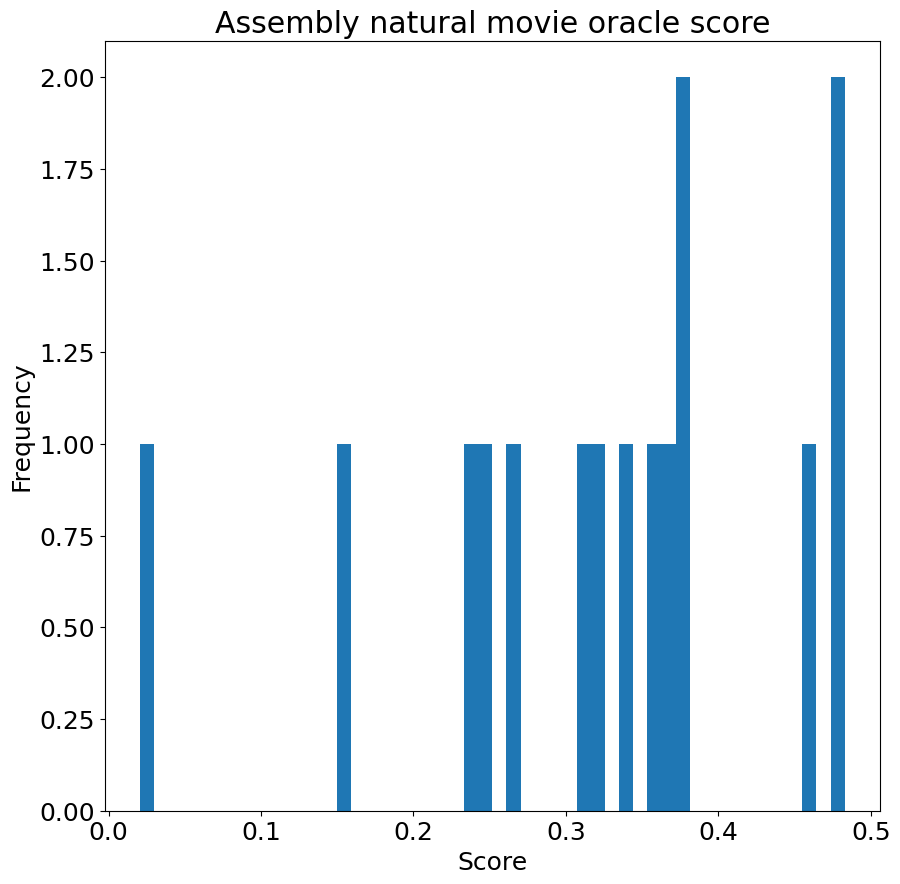

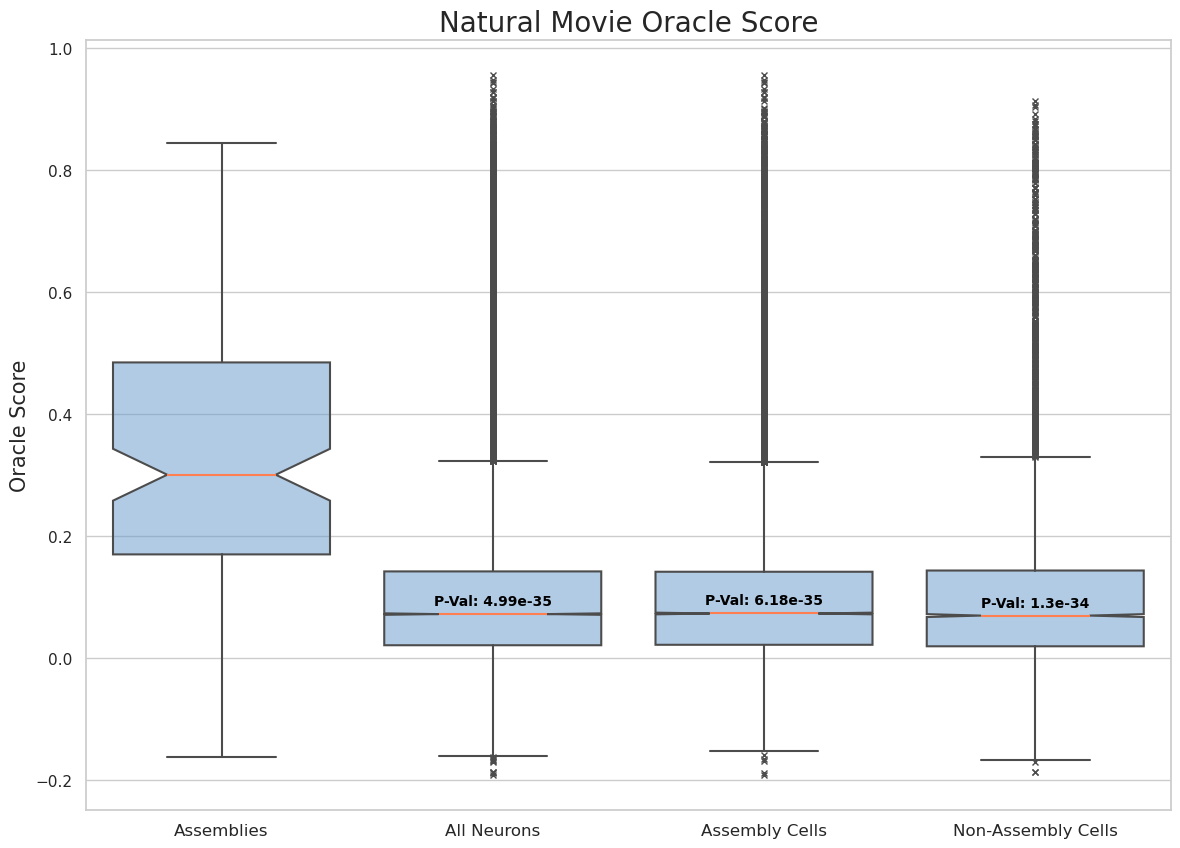

In [10]:
pika_rois_all_dict = {}
pika_rois_in_assembly_dict = {}
pika_rois_no_assembly_dict = {}
for plane_n, roi_ns in rois_dict.items():
    pika_rois = []
    pika_rois_in_assembly = []
    pika_rois_no_assembly = []
    # print(plane_n)
    for roi_n in roi_ns:
        score = daf.get_pika_classifier_score(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n)
        if score > 0.5:  # Using the threshold from team PIKA, per https://github.com/zhuangjun1981/v1dd_physiology/blob/main/v1dd_physiology/example_notebooks/2022-06-27-data-fetching-basic.ipynb
            pika_rois.append(roi_n)
            if int(roi_n[4:]) in assembly_neurons:
                pika_rois_in_assembly.append(roi_n)
            else:
                pika_rois_no_assembly.append(roi_n)
    pika_rois_all_dict[plane_n] = pika_rois
    pika_rois_in_assembly_dict[plane_n] = pika_rois_in_assembly
    pika_rois_no_assembly_dict[plane_n] = pika_rois_no_assembly

total_rois = np.sum([len(val) for val in pika_rois_all_dict.values()])
neuron_all_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_in_assembly_dict.values()])
neuron_in_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_no_assembly_dict.values()])
neuron_no_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

count_n_all = -1
count_n_in_assembly = -1
count_n_no_assembly = -1
for curr_dict, oracle_array, c in zip([pika_rois_all_dict, pika_rois_in_assembly_dict, pika_rois_no_assembly_dict], 
        [neuron_all_movie_oracle_r_values, neuron_in_assembly_movie_oracle_r_values, neuron_no_assembly_movie_oracle_r_values],
        [1,2,3]):
    for plane_n, pika_roi_ns in curr_dict.items():
        for roi_n in pika_roi_ns:
            if c == 1:
                count_n_all += 1
                current_count = count_n_all
            elif c == 2:
                count_n_in_assembly += 1
                current_count = count_n_in_assembly
            elif c == 3:
                count_n_no_assembly += 1
                current_count = count_n_no_assembly
            ### Get Time Trace
            dff, dff_ts = daf.get_single_trace(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n, trace_type='dff')

            # Get Repeated Natural Movies
            trial_fluorescence = []
            presentation = nwb_f['stimulus']['presentation']
            nm_timestamps = np.array(
                presentation['natural_movie'].get('timestamps'))
            nm_data = np.array(presentation['natural_movie'].get('data'))
            new_clips = np.where(nm_data[:, 2] == 0)[0]
            clip_duration = 300  # new_clips[1]-1
            for repeat_id in range(new_clips.shape[0]):
                frames_to_capture = np.where(dff_ts >= nm_timestamps[new_clips[repeat_id]])[
                    0][0:clip_duration]
                trial_fluorescence.append(dff[frames_to_capture])
            trial_fluorescence_np = np.array(trial_fluorescence)
            for trial_idx in range(trial_fluorescence_np.shape[0]):
                removed_trial = trial_fluorescence_np[trial_idx]
                remaining_trials = np.delete(
                    trial_fluorescence_np, trial_idx, 0)
                r, p = scipy.stats.pearsonr(
                    removed_trial, np.mean(remaining_trials, 0))
                oracle_array[current_count, trial_idx] = r

movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = assembly_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        movie_oracle_r_values[roi_n, trial_idx] = r

    # get_assembly_time_trace(trial_fluorescence_np.T, movie_oracle_r_values[roi_n, :], name=f'r_value_over_each_natural_movie_assembly{roi_n}')

    # total_movie_oracle_r_values = np.append(
    #     total_movie_oracle_r_values, movie_oracle_r_values, 0)
# Plot Movie Oracles
mean_over_holdouts = np.mean(movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Assembly natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()


plt.figure(figsize=(14, 10))
all_arr = [np.array(movie_oracle_r_values).flatten(),
            np.array(neuron_all_movie_oracle_r_values).flatten(),
            np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
            np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Assemblies", "All Neurons", "Assembly Cells", "Non-Assembly Cells"], size = 12)
ax.set_title('Natural Movie Oracle Score', size = 20)
ax.set_ylabel('Oracle Score', size = 15)

medians = np.array(
    [np.median(np.array(movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
)

vertical_offset = medians * 0.2 # offset from median for display
p_values = [np.nan,
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size='small', color='black', weight='semibold')

plt.savefig('oracle_scores_histogram_dff.png', dpi = 1200)
plt.show()

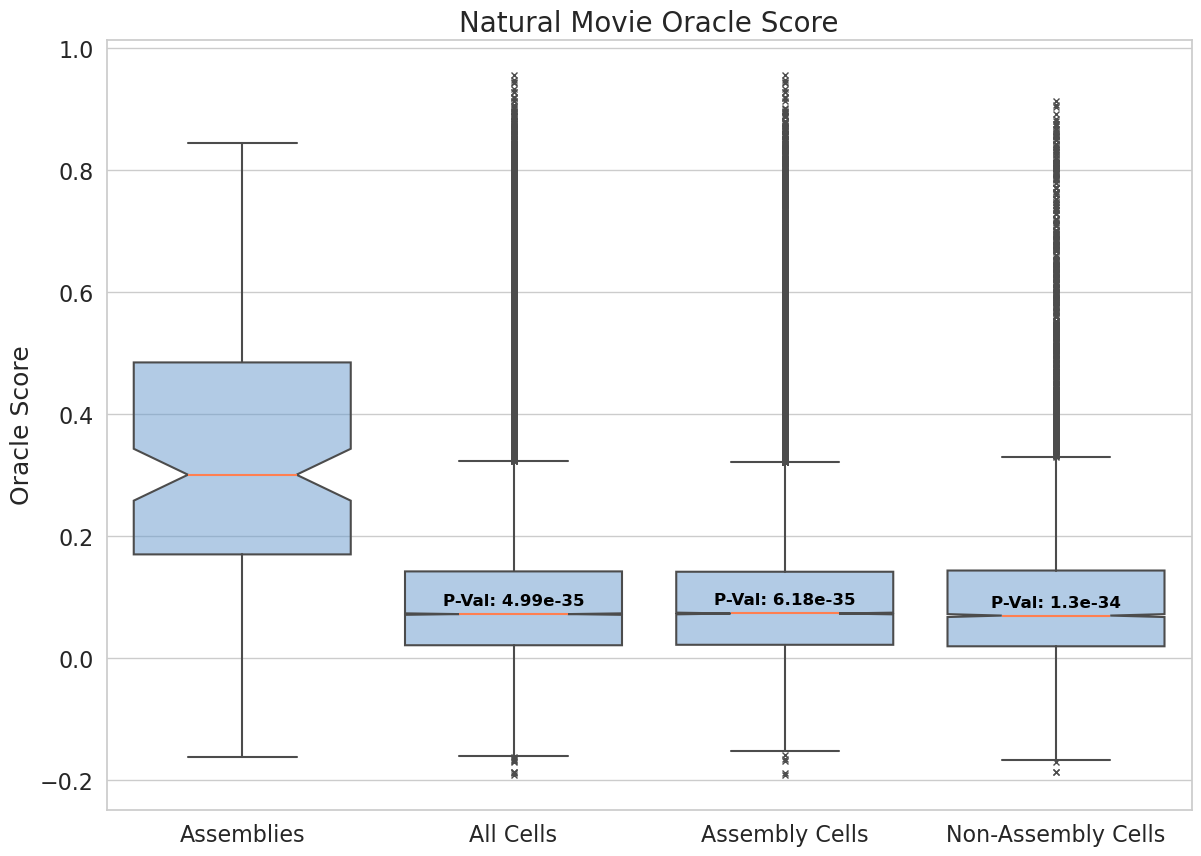

In [11]:
plt.figure(figsize=(14, 10))
all_arr = [np.array(movie_oracle_r_values).flatten(),
            np.array(neuron_all_movie_oracle_r_values).flatten(),
            np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
            np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Assemblies", "All Cells", "Assembly Cells", "Non-Assembly Cells"], size = 16)
ax.set_title('Natural Movie Oracle Score', size = 20)
ax.set_ylabel('Oracle Score', size = 18)
plt.yticks(fontsize=16)

medians = np.array(
    [np.median(np.array(movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
)

vertical_offset = medians * 0.2 # offset from median for display
p_values = [np.nan,
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size= 12, color='black', weight='semibold')

plt.savefig('oracle_scores_histogram_dff.png', dpi = 1200)
plt.show()

In [15]:
# Get repeated drifting fullscreen gratings
presentation = nwb_f['stimulus']['presentation']
dgc_onsets = np.array(
    presentation['drifting_gratings_full'].get('timestamps'))
dgc_data = np.array(presentation['drifting_gratings_full'].get('data'))
num_samples = presentation['drifting_gratings_full'].get('num_samples')
# stims = daf.get_stim_list(nwb_f=nwb_f)
# dgc_onsets = daf.get_dgc_onset_times(nwb_f, dgc_type='windowed')
# presentation = nwb_f['stimulus']['presentation']
# num_samples = np.array(
#     presentation['drifting_gratings_windowed'].get('num_samples'))
duration_sec = 2
grating_number = 0

# Get Tuning Curves and Oracles from Drfiting Gratings
trial_responses_by_assembly_and_orientation = {}
mean_response_by_assembly_and_orientation = {}
oracle_by_assembly_and_orientation = {}
for assembly_n in range(passing_roi_count):
    trial_responses_by_assembly_and_orientation[assembly_n] = {}
    mean_response_by_assembly_and_orientation[assembly_n] = []
    oracle_by_assembly_and_orientation[assembly_n] = []
    for orientation in [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 330]:
        trial_responses_by_assembly_and_orientation[assembly_n][orientation] = []
        trials = np.where(dgc_data[:,4] == orientation)[0]
        for trial_id in trials:
            mask = (f_ts < dgc_data[trial_id,1]) * (f_ts >= dgc_data[trial_id,0])
            frames_to_capture = np.where(mask)[0]
            if frames_to_capture.shape[0] > 10:
                frames_to_capture = frames_to_capture[0:10]
            trial_responses_by_assembly_and_orientation[assembly_n][orientation].append(f[frames_to_capture, assembly_n])
        # Now compute oracle
        fluorescence_across_trials_np = np.array(trial_responses_by_assembly_and_orientation[assembly_n][orientation])
        r_sum = 0
        for trial_idx in range(len(trials)):
            removed_trial = fluorescence_across_trials_np[trial_idx]
            remaining_trials = np.delete(
                fluorescence_across_trials_np, trial_idx, 0)
            if assembly_n == 3:
                print(removed_trial)
                print(np.mean(remaining_trials, 0))
            r, p = scipy.stats.pearsonr(
                removed_trial, np.mean(remaining_trials, 0))
            r_sum += np.nan_to_num(r)
        oracle_by_assembly_and_orientation[assembly_n].append(r_sum / len(trials))
        # Now compute mean response
        mean_response_by_assembly_and_orientation[assembly_n].append(np.mean(np.array(trial_responses_by_assembly_and_orientation[assembly_n][orientation])))

degree_orientations = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 330]

# Plot Assembly Orientation Mean Responses
rows = passing_roi_count // 4
if passing_roi_count % 4 > 0:
    rows += 1
fig, axes = plt.subplots(4, rows, figsize=(15,15))
fig.suptitle('Assembly Tuning Curves: DG Mean Coactivity')
for assembly_n in range(passing_roi_count):
    row = assembly_n // 4
    column = assembly_n % 4
    # axes[row, column].set_theta_direction(-1)
    # axes[row, column].set_theta_offset(np.pi / 2.0)
    axes[row, column].plot(degree_orientations, mean_response_by_assembly_and_orientation[assembly_n])
    axes[row, column].set_title(f'Assembly {assembly_n+1}')
# plt.savefig('oracle_dists2/assemblies_esteps_150000_affinity_04_session'+str(13)+'_tuning_curves_DG_fullscreen_mean_coactivity.png')
plt.close()

# , subplot_kw={'projection': 'polar'}
# Plot Assembly Orientation Oracle Values
rows = passing_roi_count // 4
if passing_roi_count % 4 > 0:
    rows += 1
fig, axes = plt.subplots(4, rows, figsize=(15,15))
fig.suptitle('Assembly Oracle Score By Orientation: DG Coactivity')
for assembly_n in range(passing_roi_count):
    row = assembly_n // 4
    column = assembly_n % 4
    # axes[row, column].set_theta_direction(-1)
    # axes[row, column].set_theta_offset(np.pi / 2.0)
    axes[row, column].plot(degree_orientations, oracle_by_assembly_and_orientation[assembly_n])
    axes[row, column].set_title(f'Assembly {assembly_n+1}')
# plt.savefig('oracle_dists2/assemblies_esteps_150000_affinity_04_session'+str(13)+'_oracle_by_orientation_DG_fullscreen_coactivity.png')
plt.close()


print("Done!")

/tmp/ipykernel_21464/3892047769.py:42: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = scipy.stats.pearsonr(


[0.05714286 0.02857143 0.02857143 0.         0.         0.
 0.         0.         0.         0.        ]
[0.01538462 0.01318681 0.01978022 0.01538462 0.01318681 0.00659341
 0.00659341 0.00659341 0.00879121 0.00879121]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02857143]
[0.01978022 0.01538462 0.02197802 0.01538462 0.01318681 0.00659341
 0.00659341 0.00659341 0.00879121 0.00659341]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01978022 0.01538462 0.02197802 0.01538462 0.01318681 0.00659341
 0.00659341 0.00659341 0.00879121 0.00879121]
[0.14285714 0.14285714 0.14285714 0.08571429 0.08571429 0.02857143
 0.02857143 0.02857143 0.02857143 0.05714286]
[0.00879121 0.0043956  0.01098901 0.00879121 0.00659341 0.0043956
 0.0043956  0.0043956  0.00659341 0.0043956 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01978022 0.01538462 0.02197802 0.01538462 0.01318681 0.00659341
 0.00659341 0.00659341 0.00879121 0.00879121]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.01978022 0.015

### Sparsity Analysis

In [16]:
def get_assembly_time_trace(coactivity_trace):
    # Set up subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color='green')
        ax[i].set_ylabel("A_{}".format(i+1))
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle("Assembly Time Trace")
    plt.savefig("stefan_time_trace.png")

def gini(x):
    """
    Calculate the Gini coefficient for a NumPy array of values.

    Args:
        x (numpy.ndarray): 1D array of values.

    Returns:
        float: Gini coefficient (ranging from 0 to 1).
    """

    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x) ** 2 * np.mean(x))

def plot_ginis(coactivity_trace):
    num_assemblies = coactivity_trace.shape[1]
    print("Old version ", coactivity_trace[1].shape)
    print("New Version ", coactivity_trace[:,1].shape)
    gini_values = [gini(coactivity_trace[:,i]) for i in range(num_assemblies)]
    labels = [f'A {i+1}' for i in range(num_assemblies)]

    df = pd.DataFrame({'gini': gini_values, 'labels': labels})

    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x = df.labels,
                     y = df.gini,
                     color= (.4, .6, .8, .5)
                     )
    ax.set_title('Sparsity of Assembly Co-Activity', size = 20)
    ax.set_xticklabels(labels, size = 12)
    ax.set_ylabel('Gini Coefficient', size = 15)
    ax.set_xlabel('Assemblies', size = 15)

    # # Create a base bar plot
    # plt.figure()
    # plt.bar(x=np.arange(len(gini_values)), height=gini_values, tick_label=labels)

    # # Apply Labels:
    # plt.title("Assembly Sparsity")            # Add a title
    # plt.xlabel("Assemblies")                 # Label the x-axis
    # plt.ylabel("Gini Coefficient")                     # Label the y-axis

    # # Remove chartjunk (redundant elements)
    # plt.tick_params(axis='both', which='both', length=0)  # Hide ticks
    # plt.gca().spines['top'].set_visible(False)            # Hide top spine
    # plt.gca().spines['right'].set_visible(False)          # Hide right spine

    # Add annotations for clarity (optional)
    for i, value in enumerate(gini_values):
        plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    plt.savefig('sparsity_with_Gini_coefficient_by_assembly.png', dpi = 1200)

In [18]:
with open('../Figure3/map_ordered_to_sgc_output.pickle', 'rb') as f:
    map_ordered_to_sgc_output = pickle.load(f)
map_ordered_to_sgc_output

FileNotFoundError: [Errno 2] No such file or directory: '../Figure3/map_ordered_to_sgc_output.pickle'

In [ ]:
ACTIVITY_RASTER = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat", struct_as_record=True, squeeze_me=True)
SGC_ASSEMBLIES = scipy.io.loadmat(
    "../Data/Session13/Assembly_Files/esteps_150000_affinity_04_sessionM409828_13_SGC-ASSEMBLIES.mat", struct_as_record=True, squeeze_me=True)

#print(ACTIVITY_RASTER.keys())

activity_raster = ACTIVITY_RASTER['activity_raster']
activity_raster_peaks = ACTIVITY_RASTER['activity_raster_peaks']

coactivity_trace = activity_raster.mean(axis=1)

assemblies = SGC_ASSEMBLIES['assemblies']
#print(assemblies)
assembly_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in assemblies]).T

scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')

correct_order = []
for i in map_ordered_to_sgc_output.values():
    correct_order.append(i)
correct_order = np.array(correct_order)


ordered_assembly_coactivity_trace = assembly_coactivity_trace[:,correct_order - 1]

In [ ]:
assemblies = SGC_ASSEMBLIES['assemblies']
ordered_assemblies = assemblies[correct_order- 1]
for A in ordered_assemblies:
    print(len(A))

1016
542
328
325
230
188
187
181
121
114
112
61
48
35
23


Old version  (15,)
New Version  (21616,)


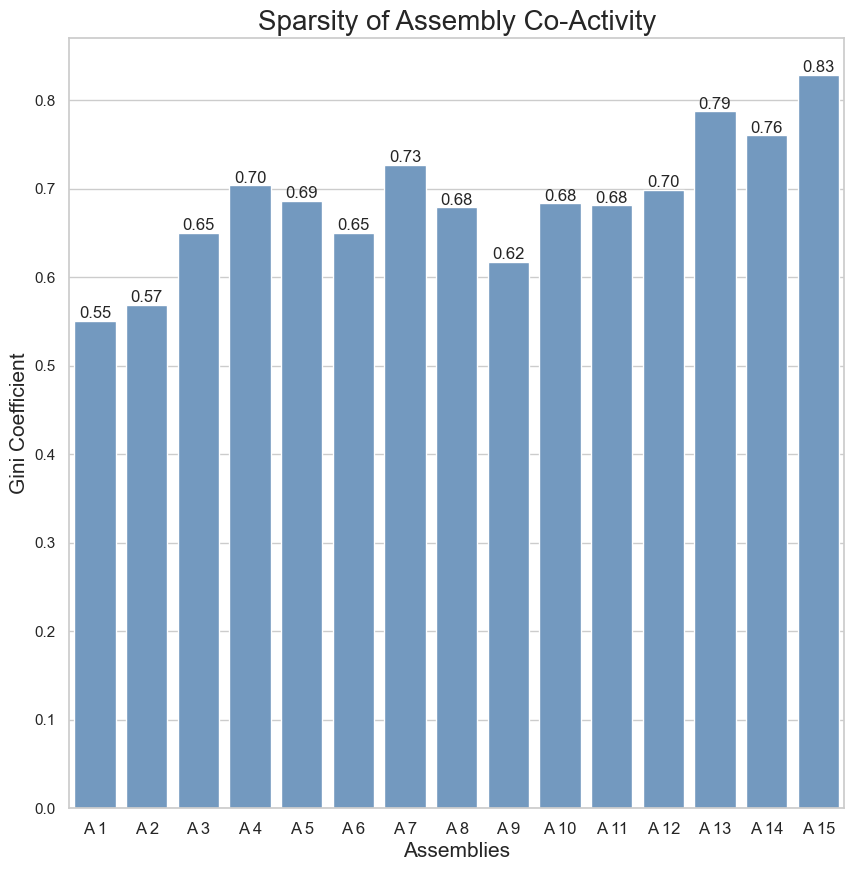

In [ ]:
# new_ordered_assembly_coactivity_trace = np.vstack(
#     [activity_raster[:, A-1].mean(axis=1) for A in ordered_assemblies]).T
# new_ordered_assembly_coactivity_trace.shape

#get_assembly_time_trace(assembly_coactivity_trace)
plot_ginis(ordered_assembly_coactivity_trace)

### Setting up Natural Movie Work

In [ ]:
import v1dd_physiology.data_fetching as daf
nwb_f = h5py.File('M409828_13_20181213.nwb', 'r')

In [ ]:
sess_id = daf.get_session_id(nwb_f=nwb_f)
print(sess_id)

plane_ns = daf.get_plane_names(nwb_f=nwb_f)
print("Planes: ", plane_ns)

for plane_n in plane_ns:
    depth = daf.get_plane_depth(nwb_f=nwb_f, plane_n=plane_n)
    print(f'depth of {plane_n}: {depth} um')

M409828_13
Planes:  ['plane0', 'plane1', 'plane2', 'plane3', 'plane4', 'plane5']
depth of plane0: 242 um
depth of plane1: 258 um
depth of plane2: 274 um
depth of plane3: 290 um
depth of plane4: 306 um
depth of plane5: 322 um


In [ ]:
# Get Repeated Natural Movies (11 NATURAL MOVIES SHOWN 9 TIMES)
# trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented
new_clips = np.where(nm_data[:, 2] == 0)[0] # get the index where a new clip rotation begins (frame numbers repeat)
clip_duration = 300  

# new_clips[1]-1
# for repeat_id in range(new_clips.shape[0]):
#     frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
#         0][0:clip_duration]
#     trial_fluorescence.append(f[frames_to_capture])
#     trial_fluorescence_np = np.array(trial_fluorescence)
#     for trial_idx in range(trial_fluorescence_np.shape[0]):
#         removed_trial = trial_fluorescence_np[trial_idx]
#         remaining_trials = np.delete(
#             trial_fluorescence_np, trial_idx, 0)
#         r, p = scipy.stats.pearsonr(
#             removed_trial, np.mean(remaining_trials, 0))
#         oracle_array[current_count, trial_idx] = r

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/509438745.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/509438745.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented


In [ ]:
f = ordered_assembly_coactivity_trace
passing_roi_count = f.shape[1] # 15

coactivity_during_movie = np.zeros((passing_roi_count, 300))
results = {}
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))

# Get Repeated Natural Movies
trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data'))[:-900] # don't use the last 900 frames, these are the "short" nms which are unrelated
new_clips = np.where(nm_data[:, 2] == 0)[0]
clip_duration = 300  # new_clips[1]-1

clip_ids = []
assembly_coactivity_time_traces = []
start_of_nms = np.where(f_ts > nm_data[0,0])[0][0] # find the frames where the natural movies start to be presented
end_of_nms = np.where(f_ts > nm_data[-1,1])[0][0] # find the frames where the natural movies finish presenting
for time_idx in range(start_of_nms, end_of_nms):
    idx_nm = np.where(nm_data[:,1] > f_ts[time_idx])[0][0] # get the first index
    total_frame_presented = nm_data[idx_nm, 2]
    within_repeats_frame_num = total_frame_presented % 3600
    clip_id = within_repeats_frame_num // 300
    clip_ids.append(clip_id)
    assembly_coactivity_time_traces.append(ordered_assembly_coactivity_trace[time_idx,:])

clip_ids = np.array(clip_ids).reshape(-1,1)
assembly_coactivity_time_traces = np.array(assembly_coactivity_time_traces)

####print(trial_fluorescence_np.shape)
# for trial_idx in range(trial_fluorescence_np.shape[0]):
#     removed_trial = trial_fluorescence_np[trial_idx]
#     remaining_trials = np.delete(
#         trial_fluorescence_np, trial_idx, 0)
#     r, p = scipy.stats.pearsonr(
#         removed_trial, np.mean(remaining_trials, 0))
#     movie_oracle_r_values[roi_n, trial_idx] = r

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3804506842.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3804506842.py:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3804506842.py:15: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data'))[:-900] # don't use the last 900 frames, these are the "short" nms which are unrelated


In [ ]:
clip_ids.shape, assembly_coactivity_time_traces.shape

((13087, 1), (13087, 15))

In [ ]:
nm_dff = np.load("../Data/Session13/sessionM409828_13_nm_dff.npy") # stefan extracted
nm_events = np.load("../Data/Session13/sessionM409828_13_nm_events.npy") # stefan extracted
nm_stimulus = np.load("../Data/Session13/sessionM409828_13_nm_stimulus.npy") 
# nm_stimulus is not time locked to the fluorescence presentation, should not use it for defining clip_ids. 

### Decoding of the Natural Movies

In [ ]:
np.unique(clip_ids)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize lists to store accuracy for each neuron
accuracies = []

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids, test_size=0.2, random_state=74)

# Initialize and train the Lasso Regression model
alpha = 0.1  # Regularization parameter
lasso_model = Ridge(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Make predictions
predictions = lasso_model.predict(X_test)

# Round the predictions to the nearest integer to get the decoded clip IDs
decoded_clip_ids = predictions.round().astype(int)

# Print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, decoded_clip_ids))


# # Create a dataframe to store the results
# results_df = pd.DataFrame({'Assembly': range(1, num_assemblies + 1), 'Accuracy': accuracies})

# # Plot the results using Seaborn
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Assembly', y='Accuracy', data=results_df, palette='viridis')
# plt.title('Accuracy of Decoding Natural Movie Clip IDs for Each Assembly')
# plt.xlabel('Neuron')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy range
# plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Accuracy Score of 0.14285714285714285


Accuracy Score of 0.7459893048128342


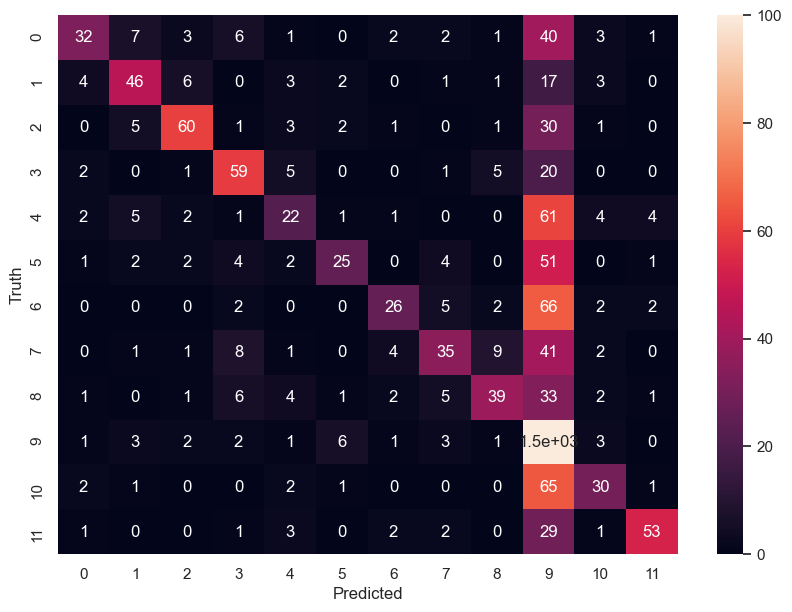

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

# # assuming clip_ids and assembly_coactivity_time_traces are your numpy arrays
# clip_ids = np.random.randint(0, 12, size=(13087, 1)) 
# assembly_coactivity_time_traces = np.random.rand(13087, 15)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# train the model
clf = RandomForestClassifier(n_estimators=100, random_state=74)
clf.fit(X_train, y_train)

# predict the clip_ids
y_pred = clf.predict(X_test)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
# The columns represent the original or expected class distribution, and the 
# rows represent the predicted or output distribution by the classifier.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, vmax = 100)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Accuracy Score of 0.7433155080213903


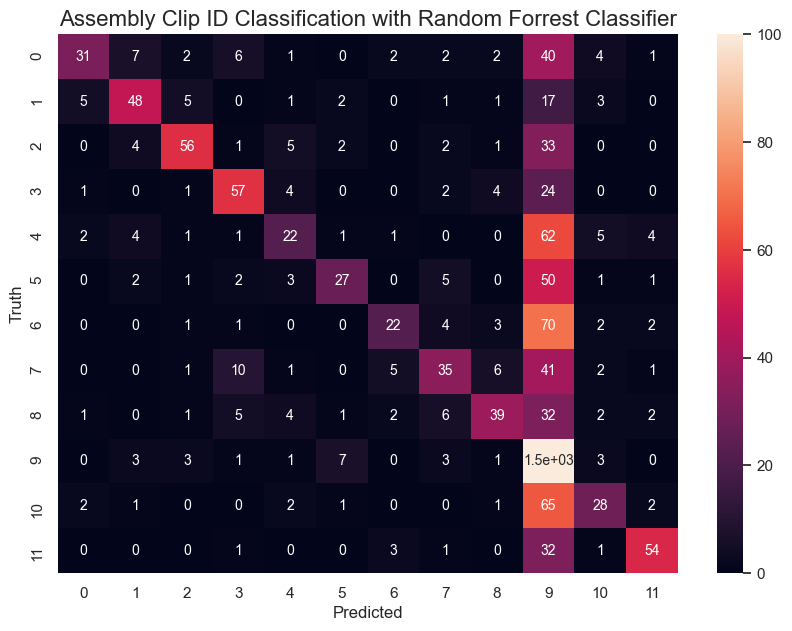

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# define the model
clf = RandomForestClassifier(random_state=74)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create the grid search object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

# fit the grid search
grid_search.fit(X_train, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
plt.title("Assembly Clip ID Classification with Random Forrest Classifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
# from sklearn.svm import SVC

# # split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# #SVMs work best when the data is scaled
# from sklearn.preprocessing import StandardScaler
# # fit the scaler to the training data and transform it, and apply it to test
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # define the model
# clf = SVC(random_state=74)

# # define the parameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }

# # create the grid search object
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

# # fit the grid search
# grid_search.fit(X_train_scaled, y_train)

# # get the best model
# best_clf = grid_search.best_estimator_

# # predict the clip_ids
# y_pred = best_clf.predict(X_test_scaled)

# # print out the accuracy
# print("Accuracy Score of", accuracy_score(y_test, y_pred))

# # plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
# plt.title("Assembly Clip ID Classification with Support Vector Machine", fontsize=16)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

Accuracy Score of 0.767379679144385


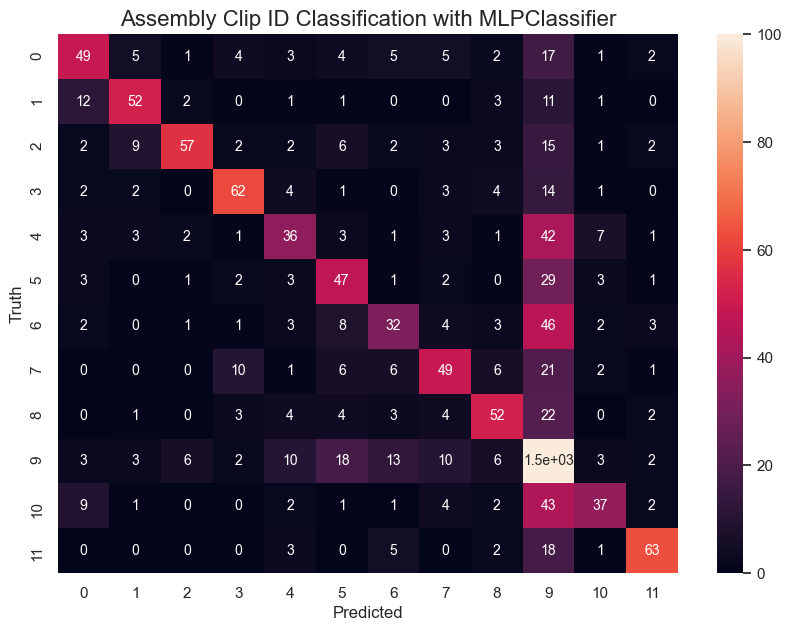

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(assembly_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=74)

# define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [500]
}

# create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid search
grid_search.fit(X_train_scaled, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
plt.title("Assembly Clip ID Classification with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('assembly_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 Best estimator:
MLPClassifier(alpha=0.05, batch_size=128, hidden_layer_sizes=(100, 100),
              max_iter=500, random_state=74)

 Best hyperparameters:
{'activation': 'relu', 'alpha': 0.05, 'batch_size': 128, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


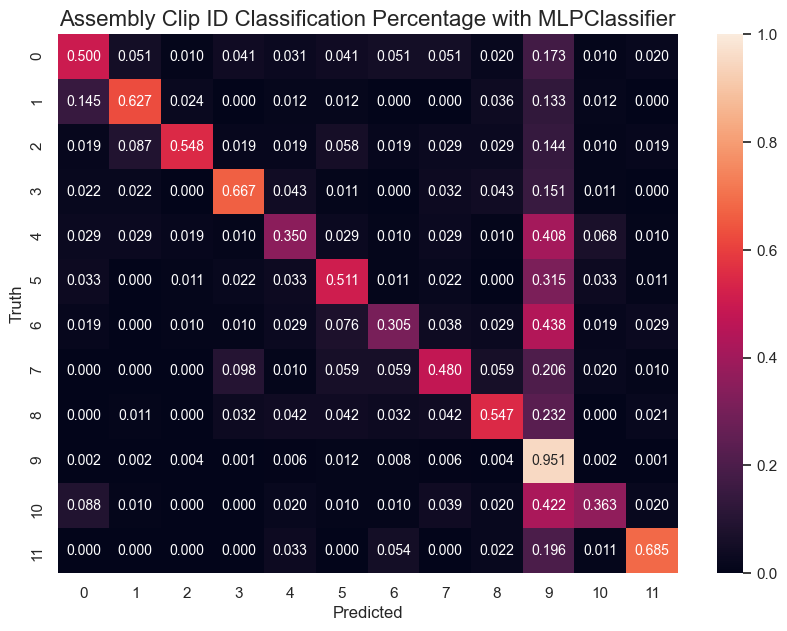

In [ ]:
#### Develop normalized Heatmap
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(cm_norm, annot=True, vmax = 1, fmt=".3f", annot_kws={"size": 35 / np.sqrt(len(cm))})
plt.title("Assembly Clip ID Classification Percentage with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('assembly_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

(array([ 968.,  487.,  484.,  484.,  485.,  484.,  484.,  484., 7759.,
         968.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

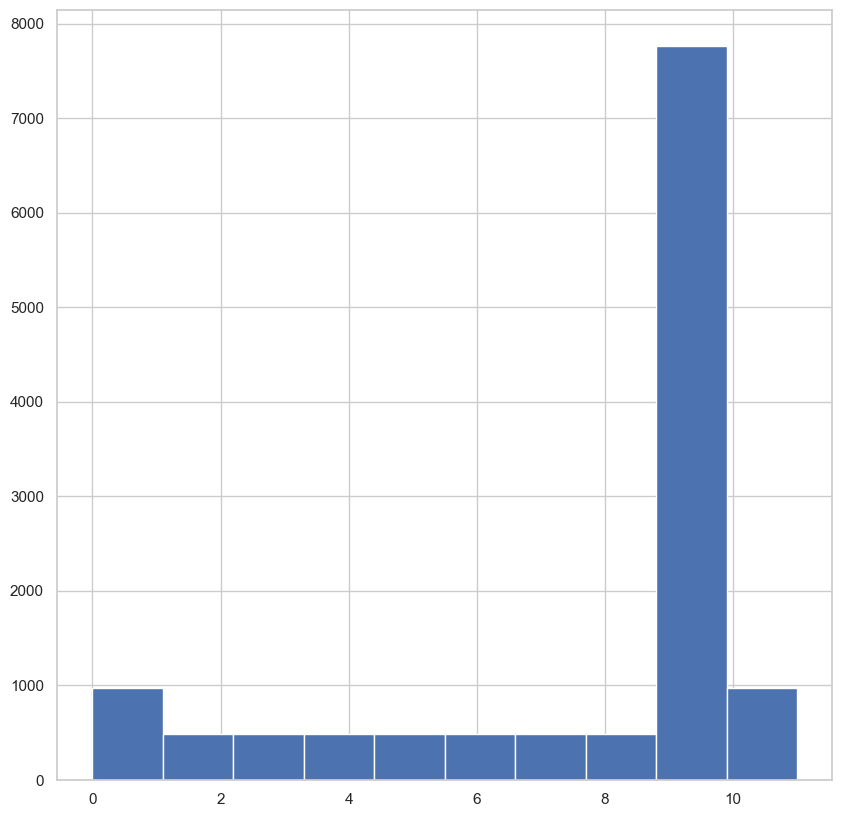

In [ ]:
plt.hist(clip_ids)

### Producing Decoder Null Model
Null Model to Assemblies will be Random 'Ensemble' of Neurons of the same sizes

Framework:
1. Produce 'random_ensembles' with ids similar to the setup of assemblies
2. Check the raster plots produced by first algorithmic step of SGC to see if we can use that
3. Calculate a co-activity trace of each 'random_ensemble', check the trace to those of assemblies to see differences
4. Prepare Decoding Framework by setting the time scale for coactiivity traces to the same as the clip ids
5. Run decoding framework in the same way that was produced with assemblies and compare results

In [19]:
random.seed(47)
np.random.seed(47)

In [20]:
### STEP 1: Produce 'random_ensembles': Random Collections of Neurons that are same sizes as the assemblies. 
### Overlap is fine so we don't have to worry about that.
random.seed(47)
np.random.seed(47)

SGC_ASSEMBLIES = scipy.io.loadmat(
    "./data_files/v1dd/functional/final/esteps_150000_affinity_04_sessionM409828_13_SGC-ASSEMBLIES.mat", struct_as_record=True, squeeze_me=True)
assemblies = SGC_ASSEMBLIES['assemblies']

dF_trace = np.load("./data_files/v1dd/functional/final/sessionM409828_13_dff.npy")
num_neurons = dF_trace.shape[1]

random_ensembles = []
for A in assemblies:
    curr_length = len(A)
    # get random ids, make sure there are no repeats in the ids for that specific ensemble
    random_ensembles.append(np.sort(np.array(random.sample(range(num_neurons), curr_length))))

# Order the random ensembles by size
random_ensembles.sort(key = len)
random_ensembles.reverse()


[array([   7,    8,   10, ..., 2705, 2706, 2707]), array([   3,   11,   12,   14,   17,   19,   23,   28,   35,   41,   58,
         64,   71,   82,   83,   94,   96,   98,   99,  101,  114,  127,
        130,  132,  138,  143,  144,  148,  149,  156,  159,  163,  165,
        166,  170,  172,  189,  190,  196,  205,  208,  214,  218,  235,
        239,  243,  245,  251,  256,  258,  259,  267,  269,  272,  274,
        281,  285,  286,  316,  317,  319,  322,  330,  334,  337,  338,
        346,  348,  363,  365,  368,  376,  379,  387,  392,  394,  401,
        402,  407,  413,  414,  417,  426,  435,  453,  454,  458,  461,
        471,  475,  480,  481,  483,  486,  489,  503,  519,  521,  526,
        529,  532,  562,  570,  571,  587,  591,  598,  599,  609,  613,
        623,  626,  633,  645,  651,  653,  654,  656,  668,  672,  687,
        692,  694,  698,  699,  700,  710,  718,  721,  730,  737,  752,
        753,  754,  756,  759,  761,  766,  770,  773,  781,  783,  793,


In [21]:
with open('random_ensembles.pkl', 'wb') as f:
    pickle.dump(random_ensembles, f)
random_ensembles

[array([   7,    8,   10, ..., 2705, 2706, 2707]),
 array([   3,   11,   12,   14,   17,   19,   23,   28,   35,   41,   58,
          64,   71,   82,   83,   94,   96,   98,   99,  101,  114,  127,
         130,  132,  138,  143,  144,  148,  149,  156,  159,  163,  165,
         166,  170,  172,  189,  190,  196,  205,  208,  214,  218,  235,
         239,  243,  245,  251,  256,  258,  259,  267,  269,  272,  274,
         281,  285,  286,  316,  317,  319,  322,  330,  334,  337,  338,
         346,  348,  363,  365,  368,  376,  379,  387,  392,  394,  401,
         402,  407,  413,  414,  417,  426,  435,  453,  454,  458,  461,
         471,  475,  480,  481,  483,  486,  489,  503,  519,  521,  526,
         529,  532,  562,  570,  571,  587,  591,  598,  599,  609,  613,
         623,  626,  633,  645,  651,  653,  654,  656,  668,  672,  687,
         692,  694,  698,  699,  700,  710,  718,  721,  730,  737,  752,
         753,  754,  756,  759,  761,  766,  770,  773,  781,

In [22]:
print("Assembly Lengths")
assemblies = list(assemblies)
assemblies.sort(key = len)
assemblies.reverse()
print([len(A) for A in assemblies])

print("Random Ensemble Lengths")
print([len(r) for r in random_ensembles])

Assembly Lengths
[1016, 542, 328, 325, 230, 188, 187, 181, 121, 114, 112, 61, 48, 35, 23]
Random Ensemble Lengths
[1016, 542, 328, 325, 230, 188, 187, 181, 121, 114, 112, 61, 48, 35, 23]


In [23]:
### STEP 2: Use the raster plots produced by SGC
### STEP 3: Produce a co-activity trace of each random_ensemble
ACTIVITY_RASTER = scipy.io.loadmat(
    "data_files/v1dd/functional/final/esteps_150000_affinity_04_sessionM409828_13_ACTIVITY-RASTER.mat", struct_as_record=True, squeeze_me=True)

activity_raster = ACTIVITY_RASTER['activity_raster']
#activity_raster_peaks = ACTIVITY_RASTER['activity_raster_peaks']

coactivity_trace = activity_raster.mean(axis=1)

# Assembly Coactivity Trace
assembly_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in assemblies]).T

# Random Ensemble Coactivity Trace
random_ensembles_coactivity_trace = np.vstack(
    [activity_raster[:, A-1].mean(axis=1) for A in random_ensembles]).T

In [24]:
print(random_ensembles_coactivity_trace[0:10, 0])
print(random_ensembles_coactivity_trace[0:10, 1])

[0.00492126 0.00885827 0.01279528 0.01870079 0.02165354 0.02559055
 0.02854331 0.02362205 0.01476378 0.02165354]
[0.00553506 0.00922509 0.01845018 0.0295203  0.02767528 0.02583026
 0.03321033 0.0202952  0.02214022 0.03136531]


In [25]:
def get_ensemble_time_trace(coactivity_trace, title):
    # Set up three subplots
    num_assemblies = coactivity_trace.shape[1]
    fig, ax = plt.subplots(num_assemblies, 1, figsize=(12, 12))

    # plot
    for i in range(num_assemblies):
        ax[i].plot(coactivity_trace[:, i], color='green')
        ax[i].set_ylabel("Co-A")
        ax[i].set_xlabel("Time Steps")
        ax[i].grid()

    fig.suptitle(title)
    #plt.savefig(f"oracle_dists2/assemblies_esteps_150000_affinity_04_{name}.png", dpi = 1200)

In [ ]:
### Plot the assembly coactivity traces in order
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_ensemble_time_trace(assembly_coactivity_trace, title = "Co-Activity Time Trace")

In [ ]:
### Plot the random ensemble coactivity traces in order
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_ensemble_time_trace(random_ensembles_coactivity_trace, title = "Random Ensemble Time Trace")

Mean R^2 Score: 0.28546639637315446
Mean R^2 Score Random Ensemble: 0.8272308146355204
RanksumsResult(statistic=-15.514671427047055, pvalue=2.7604415034309525e-54)
1.3802207517154763e-54


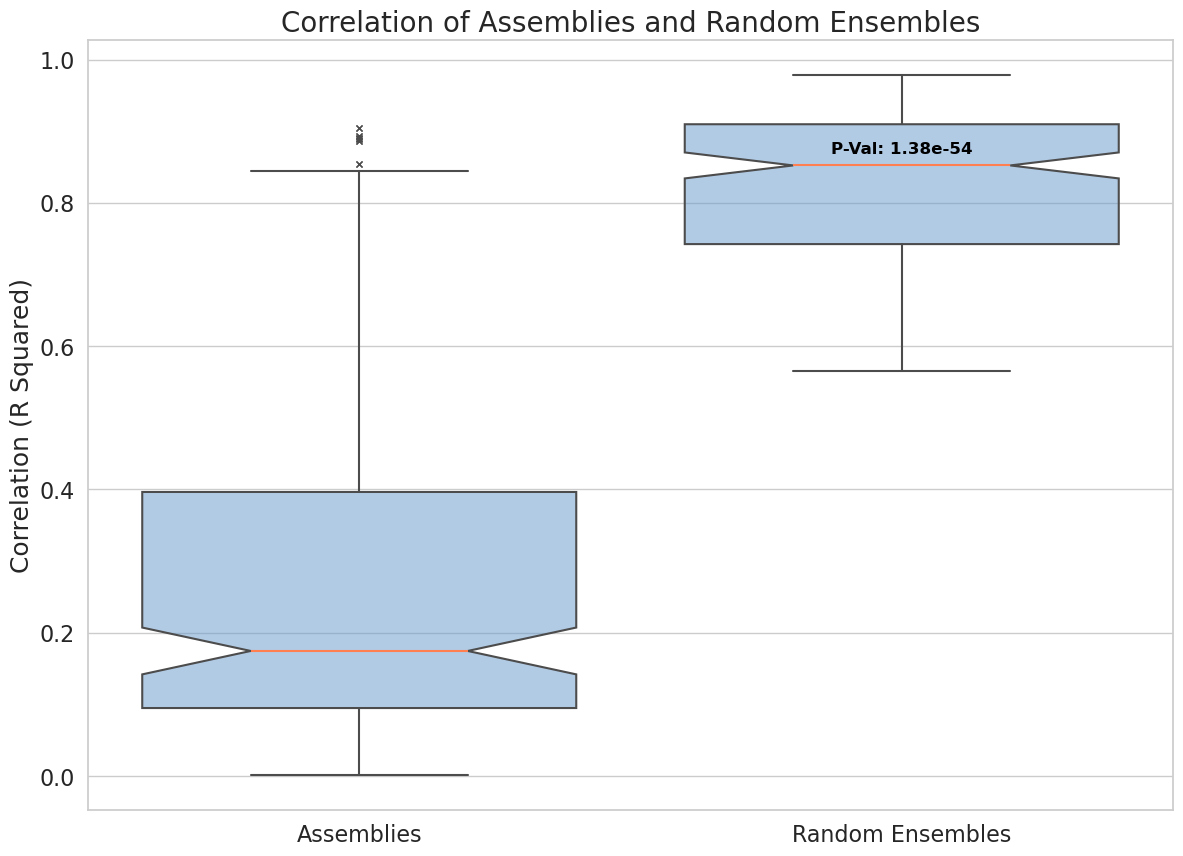

In [37]:
# Compare correlation of asesmblies and random ensembles
correlate_assembly_traces_vs_random_ensembles(assembly_coactivity_trace, random_ensembles_coactivity_trace, scores_in_order, name='assemblies_vs_ensembles')

In [ ]:
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_ensemble_time_trace(assembly_coactivity_trace, title = "Co-Activity Time Trace")

NameError: name 'np' is not defined

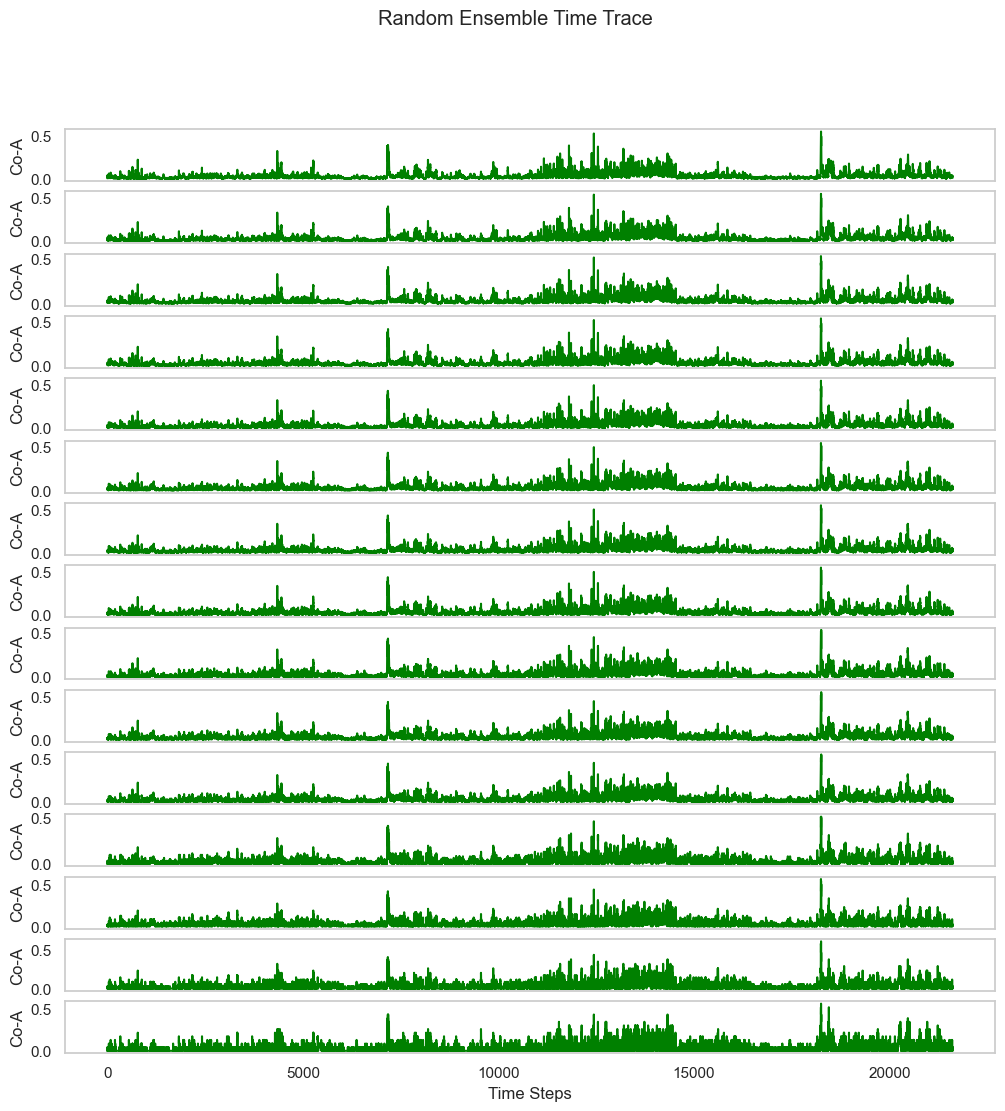

In [ ]:
scores_in_order = np.load('oracle_dists/assemblies_esteps_150000_affinity_04_session13_natural_movie_oracle_scores.npy')
get_ensemble_time_trace(random_ensembles_coactivity_trace, title = "Random Ensemble Time Trace")

In [ ]:
### Step 4: Prepare Decoding Framework in the same way as Assemblies
import v1dd_physiology.data_fetching as daf
nwb_f = h5py.File('M409828_13_20181213.nwb', 'r')

# Get Repeated Natural Movies (11 NATURAL MOVIES SHOWN 9 TIMES)
# trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented
new_clips = np.where(nm_data[:, 2] == 0)[0] # get the index where a new clip rotation begins (frame numbers repeat)
clip_duration = 300  

f = random_ensembles_coactivity_trace
passing_roi_count = f.shape[1] # 15

coactivity_during_movie = np.zeros((passing_roi_count, 300))
results = {}
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))

# Get Repeated Natural Movies
trial_fluorescence = []
presentation = nwb_f['stimulus']['presentation']
nm_timestamps = np.array(
    presentation['natural_movie'].get('timestamps'))
nm_data = np.array(presentation['natural_movie'].get('data'))[:-900] # don't use the last 900 frames, these are the "short" nms which are unrelated
new_clips = np.where(nm_data[:, 2] == 0)[0]
clip_duration = 300  # new_clips[1]-1

clip_ids = []
random_ensemble_coactivity_time_traces = []
start_of_nms = np.where(f_ts > nm_data[0,0])[0][0] # find the frames where the natural movies start to be presented
end_of_nms = np.where(f_ts > nm_data[-1,1])[0][0] # find the frames where the natural movies finish presenting
for time_idx in range(start_of_nms, end_of_nms):
    idx_nm = np.where(nm_data[:,1] > f_ts[time_idx])[0][0] # get the first index
    total_frame_presented = nm_data[idx_nm, 2]
    within_repeats_frame_num = total_frame_presented % 3600
    clip_id = within_repeats_frame_num // 300
    clip_ids.append(clip_id)
    random_ensemble_coactivity_time_traces.append(random_ensembles_coactivity_trace[time_idx,:])

clip_ids = np.array(clip_ids).reshape(-1,1)
random_ensemble_coactivity_time_traces = np.array(random_ensemble_coactivity_time_traces)

print(clip_ids.shape, random_ensemble_coactivity_time_traces.shape)

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3135718673.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3135718673.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data')) # columns name dataset, gives you the start time, the end time, and the frame number for the natural movie data that was presented
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3135718673.py:20: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/3135718673.py:26: Depreca

(13087, 1) (13087, 15)


In [ ]:
### Step 5: Run Decoding Metric with Random Ensembles
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Initialize lists to store accuracy for each neuron
accuracies = []

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(random_ensemble_coactivity_time_traces, clip_ids, test_size=0.2, random_state=74)

# Initialize and train the Lasso Regression model
alpha = 0.1  # Regularization parameter
lasso_model = Ridge(alpha=alpha)
lasso_model.fit(X_train, y_train)

# Make predictions
predictions = lasso_model.predict(X_test)

# Round the predictions to the nearest integer to get the decoded clip IDs
decoded_clip_ids = predictions.round().astype(int)

# Print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, decoded_clip_ids))


# # Create a dataframe to store the results
# results_df = pd.DataFrame({'Assembly': range(1, num_assemblies + 1), 'Accuracy': accuracies})

# # Plot the results using Seaborn
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Assembly', y='Accuracy', data=results_df, palette='viridis')
# plt.title('Accuracy of Decoding Natural Movie Clip IDs for Each Assembly')
# plt.xlabel('Neuron')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for accuracy range
# plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Accuracy Score of 0.03514132925897632


Accuracy Score of 0.593964858670741


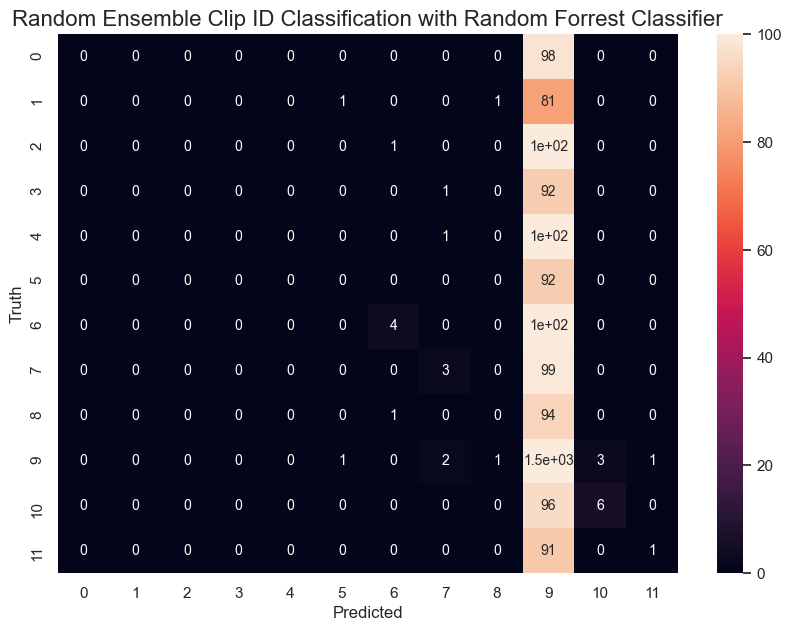

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(random_ensemble_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# define the model
clf = RandomForestClassifier(random_state=74)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# create the grid search object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)

# fit the grid search
grid_search.fit(X_train, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
plt.title("Random Ensemble Clip ID Classification with Random Forrest Classifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

Accuracy Score of 0.6027501909854851


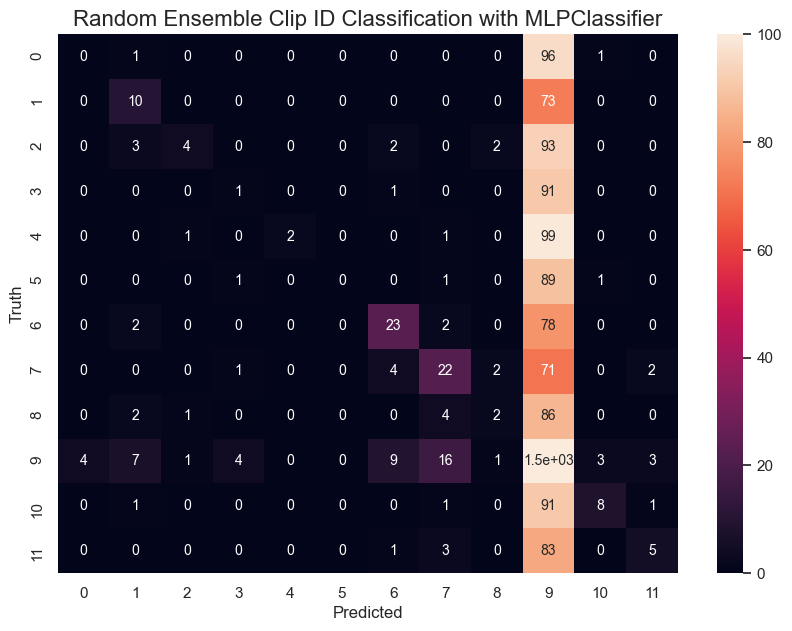

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(random_ensemble_coactivity_time_traces, clip_ids.ravel(), test_size=0.2, random_state=74)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=74)

# define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [500]
}

# create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid search
grid_search.fit(X_train_scaled, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(cm))})
plt.title("Random Ensemble Clip ID Classification with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('random_ensemble_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 Best estimator:
MLPClassifier(alpha=0.01, batch_size=256, max_iter=500, random_state=74)

 Best hyperparameters:
{'activation': 'relu', 'alpha': 0.01, 'batch_size': 256, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


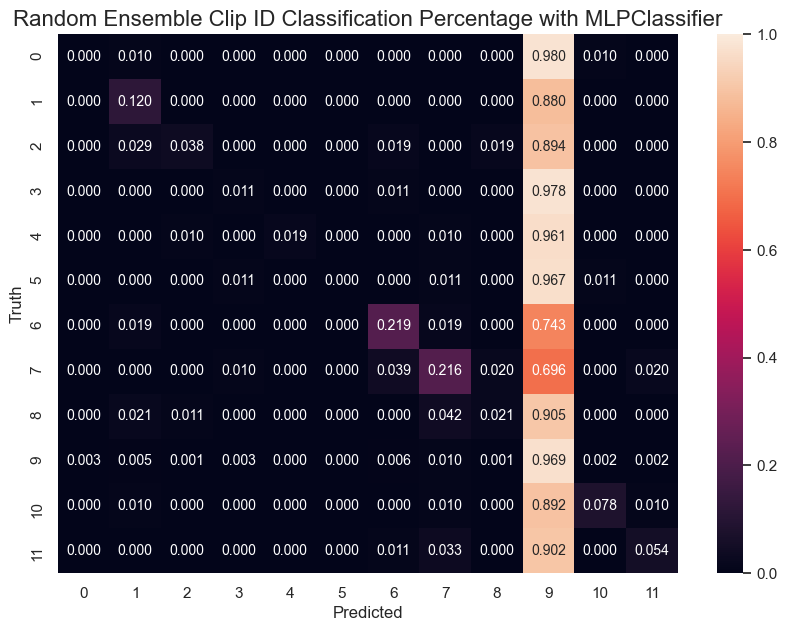

In [ ]:
#### Develop normalized Heatmap
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(cm_norm, annot=True, vmax = 1, fmt=".3f", annot_kws={"size": 35 / np.sqrt(len(cm))})
plt.title("Random Ensemble Clip ID Classification Percentage with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('random_ensemble_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

### Reproduce with Balanced Clip IDs

In [ ]:
clip_ids.shape, assembly_coactivity_time_traces.shape

((13087, 1), (13087, 15))

In [ ]:
# Get unique clip_ids and their counts
unique_clip_ids, counts = np.unique(clip_ids, return_counts=True)

# Determine the minimum count of any clip_id
min_count = np.min(counts)

# Create new lists for balanced clip_ids and corresponding assembly_coactivations
balanced_clip_ids = []
balanced_assembly_coactivations = []

# Sample min_count indices for each clip_id
for clip_id in unique_clip_ids:
    # Get indices of the current clip_id
    indices = np.where(clip_ids == clip_id)[0]
    # Randomly sample min_count indices
    np.random.seed(747)
    sampled_indices = np.random.choice(indices, min_count, replace=False)
    # Append the sampled indices' values to the new lists
    balanced_clip_ids.extend(clip_ids[sampled_indices])
    balanced_assembly_coactivations.extend(assembly_coactivity_time_traces[sampled_indices])

# Convert lists to numpy arrays
balanced_clip_ids = np.array(balanced_clip_ids)
balanced_assembly_coactivations = np.array(balanced_assembly_coactivations)

# Shuffle to ensure random distribution
shuffled_indices = np.random.default_rng(seed=747).permutation(len(balanced_clip_ids))
balanced_clip_ids = balanced_clip_ids[shuffled_indices]
balanced_assembly_coactivations = balanced_assembly_coactivations[shuffled_indices]

# Output the balanced arrays
print("Balanced clip_ids:", balanced_clip_ids)
print("Balanced assembly_coactivations:", balanced_assembly_coactivations)

Balanced clip_ids: [[ 7.]
 [ 0.]
 [11.]
 ...
 [ 1.]
 [ 1.]
 [ 2.]]
Balanced assembly_coactivations: [[0.01377953 0.02398524 0.00914634 ... 0.         0.02857143 0.        ]
 [0.05807087 0.1402214  0.06707317 ... 0.02083333 0.05714286 0.04347826]
 [0.00885827 0.01107011 0.00609756 ... 0.02083333 0.         0.        ]
 ...
 [0.02559055 0.05904059 0.01219512 ... 0.         0.         0.04347826]
 [0.0226378  0.03690037 0.0152439  ... 0.         0.         0.        ]
 [0.00984252 0.01476015 0.01829268 ... 0.         0.         0.        ]]


In [ ]:
balanced_clip_ids.shape, balanced_assembly_coactivations.shape

((5772, 1), (5772, 15))

(array([962., 481., 481., 481., 481., 481., 481., 481., 481., 962.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

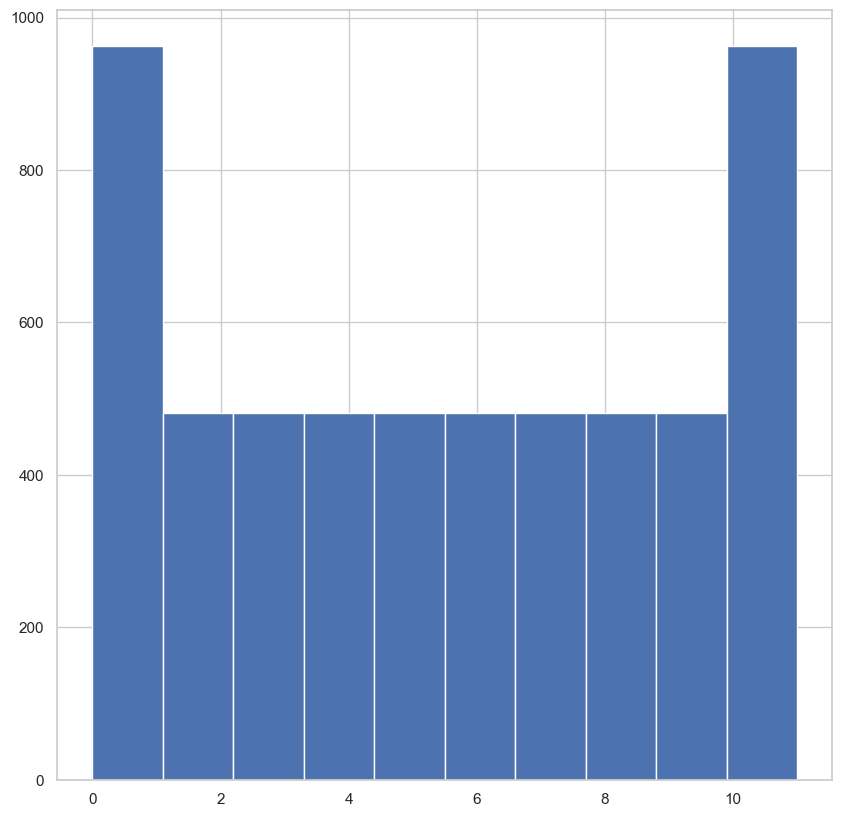

In [ ]:
plt.hist(balanced_clip_ids)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

Accuracy Score of 0.6199134199134199


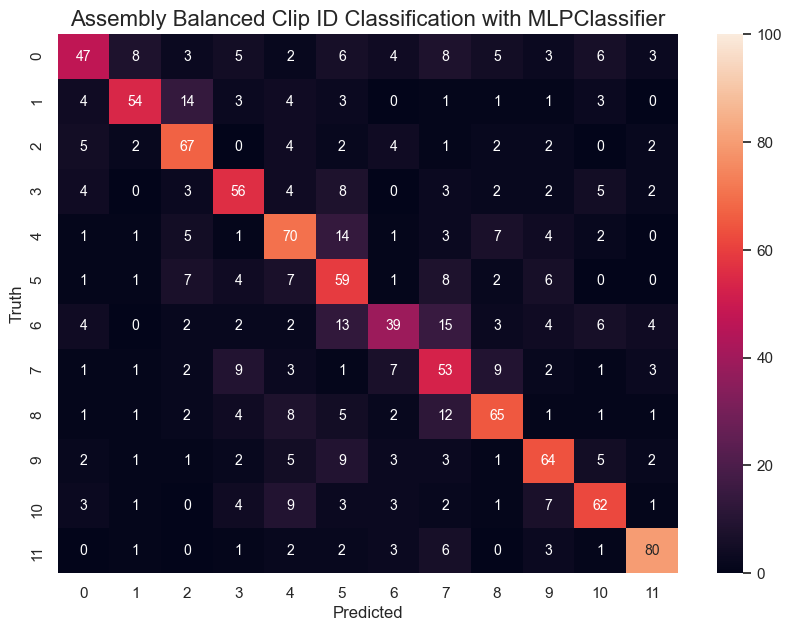

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_assembly_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=747)

# define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [500]
}

# create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid search
grid_search.fit(X_train_scaled, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
assembly_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(assembly_cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(assembly_cm))})
plt.title("Assembly Balanced Clip ID Classification with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('assembly_balanced_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 Best estimator:
MLPClassifier(alpha=0.05, batch_size=64, hidden_layer_sizes=(100, 100),
              max_iter=500, random_state=747)

 Best hyperparameters:
{'activation': 'relu', 'alpha': 0.05, 'batch_size': 64, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


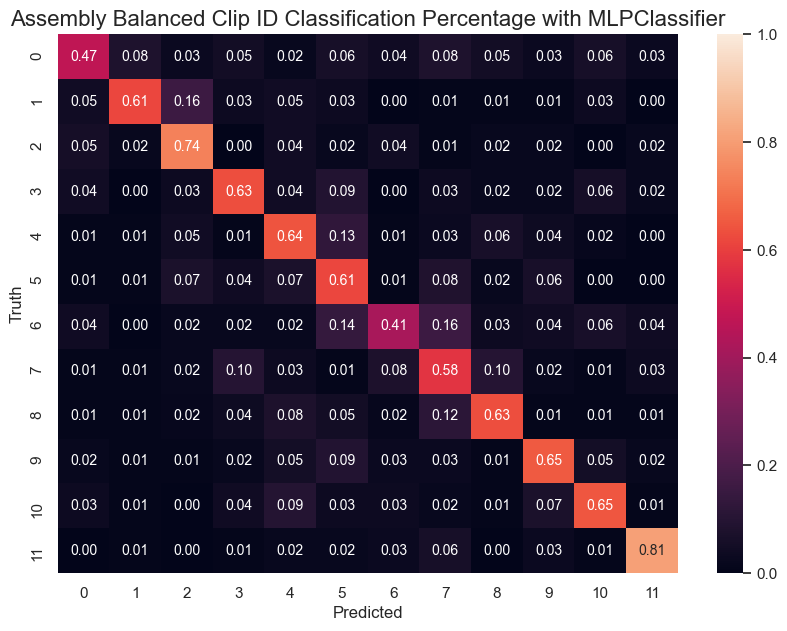

In [ ]:
#### Develop normalized Heatmap
assembly_cm_norm = assembly_cm.astype('float') / assembly_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(assembly_cm_norm, annot=True, vmax = 1, fmt=".2f", annot_kws={"size": 35 / np.sqrt(len(assembly_cm))})
plt.title("Assembly Balanced Clip ID Classification Percentage with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('assembly_balanced_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print(clip_ids.shape, random_ensemble_coactivity_time_traces.shape)

# Get unique clip_ids and their counts
unique_clip_ids, counts = np.unique(clip_ids, return_counts=True)

# Determine the minimum count of any clip_id
min_count = np.min(counts)

# Create new lists for balanced clip_ids and corresponding assembly_coactivations
balanced_clip_ids = []
balanced_random_ensemble_coactivations = []

# Sample min_count indices for each clip_id
for clip_id in unique_clip_ids:
    # Get indices of the current clip_id
    indices = np.where(clip_ids == clip_id)[0]
    # Randomly sample min_count indices
    np.random.seed(747)
    sampled_indices = np.random.choice(indices, min_count, replace=False)
    # Append the sampled indices' values to the new lists
    balanced_clip_ids.extend(clip_ids[sampled_indices])
    balanced_random_ensemble_coactivations.extend(random_ensemble_coactivity_time_traces[sampled_indices])

# Convert lists to numpy arrays
balanced_clip_ids = np.array(balanced_clip_ids)
balanced_random_ensemble_coactivations = np.array(balanced_random_ensemble_coactivations)

# Shuffle to ensure random distribution
shuffled_indices = np.random.default_rng(seed=747).permutation(len(balanced_clip_ids))
balanced_clip_ids = balanced_clip_ids[shuffled_indices]
balanced_random_ensemble_coactivations = balanced_random_ensemble_coactivations[shuffled_indices]

# Output the balanced arrays
print("Balanced clip_ids:", balanced_clip_ids)
print("Balanced random_ensemble_coactivations:", balanced_random_ensemble_coactivations)

(13087, 1) (13087, 15)
Balanced clip_ids: [[ 7.]
 [ 0.]
 [11.]
 ...
 [ 1.]
 [ 1.]
 [ 2.]]
Balanced random_ensemble_coactivations: [[0.02362205 0.02583026 0.02439024 ... 0.02083333 0.02857143 0.04347826]
 [0.06496063 0.08671587 0.07012195 ... 0.08333333 0.05714286 0.04347826]
 [0.00885827 0.01291513 0.01219512 ... 0.02083333 0.02857143 0.04347826]
 ...
 [0.03149606 0.02583026 0.04573171 ... 0.02083333 0.02857143 0.04347826]
 [0.0246063  0.03321033 0.0304878  ... 0.0625     0.08571429 0.13043478]
 [0.01082677 0.00922509 0.00609756 ... 0.         0.         0.        ]]


In [ ]:
balanced_clip_ids.shape, balanced_random_ensemble_coactivations.shape

((5772, 1), (5772, 15))

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

Accuracy Score of 0.3515151515151515


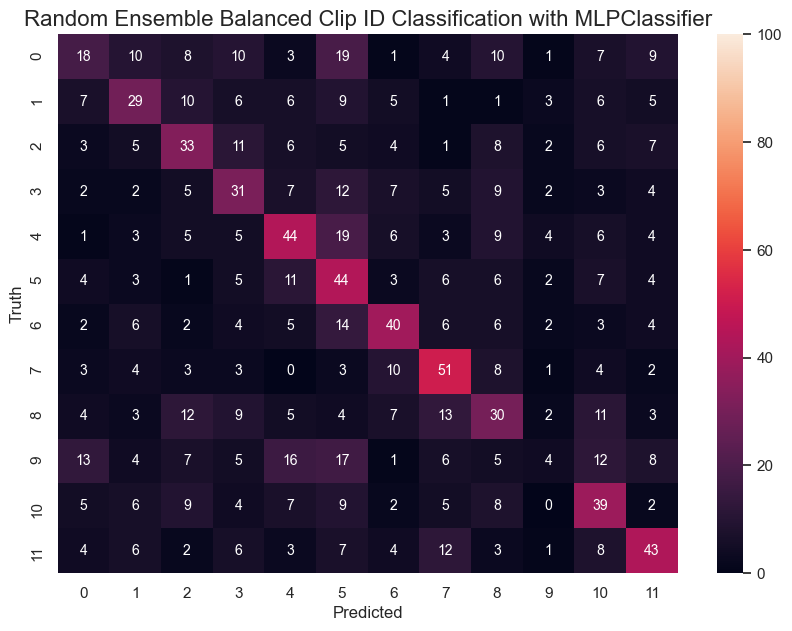

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_random_ensemble_coactivations, balanced_clip_ids.ravel(), test_size=0.2, random_state=747)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define the model
clf = MLPClassifier(random_state=747)

# define the parameter grid: checked on all and relu provided best score (makes results comparable between assembly and null sets as well)
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (50, 50, 100), (100, 100)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'batch_size': [64, 128, 256, 512, 1024],
    'max_iter': [500]
}

# create the grid search object
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# fit the grid search
grid_search.fit(X_train_scaled, y_train)

# get the best model
best_clf = grid_search.best_estimator_

# predict the clip_ids
y_pred = best_clf.predict(X_test_scaled)

# print out the accuracy
print("Accuracy Score of", accuracy_score(y_test, y_pred))

# plot the confusion matrix
rand_ensemble_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(rand_ensemble_cm, annot=True, vmax = 100, annot_kws={"size": 35 / np.sqrt(len(rand_ensemble_cm))})
plt.title("Random Ensemble Balanced Clip ID Classification with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('random_ensemble_balanced_clip_id_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best hyperparameters:')
print(grid_search.best_params_)


 Best estimator:
MLPClassifier(alpha=0.05, batch_size=256, hidden_layer_sizes=(100, 100),
              max_iter=500, random_state=747)

 Best hyperparameters:
{'activation': 'relu', 'alpha': 0.05, 'batch_size': 256, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


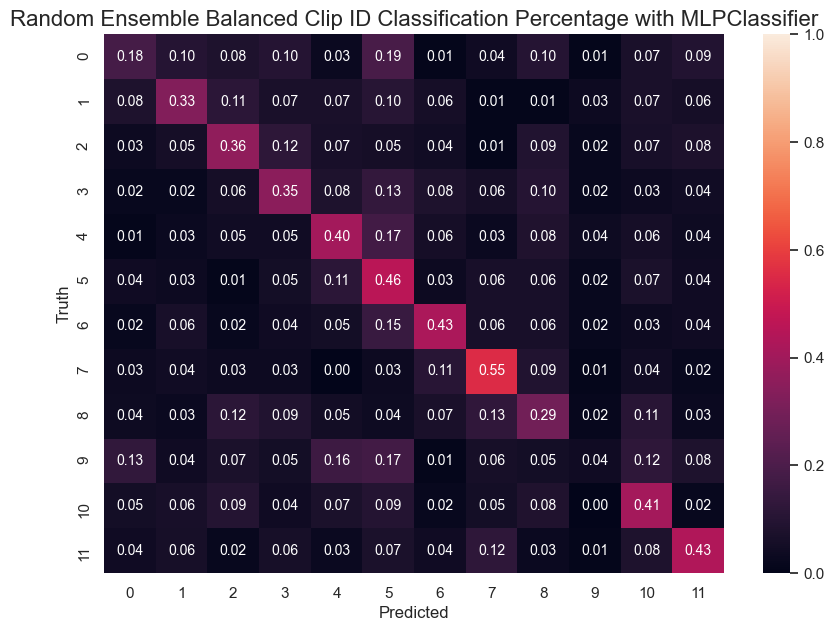

In [ ]:
#### Develop normalized Heatmap
rand_ensemble_cm_norm = rand_ensemble_cm.astype('float') / rand_ensemble_cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,7))
sns.heatmap(rand_ensemble_cm_norm, annot=True, vmax = 1, fmt=".2f", annot_kws={"size": 35 / np.sqrt(len(rand_ensemble_cm))})
plt.title("Random Ensemble Balanced Clip ID Classification Percentage with MLPClassifier", fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('random_ensemble_balanced_clip_id_percentage_decoder_MLPClassifier.png', dpi = 1200)
plt.show()

In [ ]:
### Produce Statistical Test Between Two Heatmaps
assembly_cm_norm_mean = np.mean(assembly_cm_norm.flatten())
assembly_cm_norm_std = np.std(assembly_cm_norm.flatten())
rand_ensemble_cm_mean = np.mean(rand_ensemble_cm_norm.flatten())
rand_ensemble_cm_std = np.std(rand_ensemble_cm_norm.flatten())
print(f"Assembly Heatmap: Mean = {assembly_cm_norm_mean}, Std = {assembly_cm_norm_std}")
print(f"Random Ensemble Heatmap: Mean = {rand_ensemble_cm_mean}, Std = {rand_ensemble_cm_std}")

# Mann-Whitney U test
mw_u_stat, mw_p_value = stats.mannwhitneyu(assembly_cm_norm.flatten(), rand_ensemble_cm_norm.flatten())
print(f"Mann-Whitney U test: u_stat = {mw_u_stat}, p_value = {mw_p_value}")

# Rank-biserial correlation
rank_biserial = 1 - 2 * mw_u_stat / (len(assembly_cm_norm.flatten()) * len(rand_ensemble_cm_norm.flatten()))
print(f"Mann-Whitney U Test Rank-biserial correlation = {rank_biserial}")

# Wilcoxon rank-sum
wrs_stat, wrs_p_value = stats.ranksums(assembly_cm_norm.flatten(), rand_ensemble_cm_norm.flatten())
print(f"Wilcoxon Rank-Sum U test: u_stat = {wrs_stat}, p_value = {wrs_p_value}")

Assembly Heatmap: Mean = 0.08333333333333333, Std = 0.16704721629530858
Random Ensemble Heatmap: Mean = 0.08333333333333333, Std = 0.09663954941503816
Mann-Whitney U test: u_stat = 6742.5, p_value = 2.890690643426736e-07
Mann-Whitney U Test Rank-biserial correlation = 0.3496817129629629
Wilcoxon Rank-Sum U test: u_stat = -5.130351472909284, p_value = 2.8920167547461994e-07


In [ ]:
### Statistical test of just the Diagonal, Implying Accuracy
assembly_accuracy = np.diag(assembly_cm_norm)
rand_ensemble_accuracy = np.diag(rand_ensemble_cm_norm)

assembly_accuracy_mean = np.mean(assembly_accuracy)
assembly_accuracy_std = np.std(assembly_accuracy)
rand_ensemble_accuracy_mean = np.mean(rand_ensemble_accuracy)
rand_ensemble_accuracy_std = np.std(rand_ensemble_accuracy)
print(f"Assembly Heatmap: Mean = {assembly_accuracy_mean}, Std = {assembly_accuracy_std}")
print(f"Random Ensemble Heatmap: Mean = {rand_ensemble_accuracy_mean}, Std = {rand_ensemble_cm_std}")

# Mann-Whitney U test
mw_u_stat, mw_p_value = stats.mannwhitneyu(assembly_accuracy, rand_ensemble_accuracy, alternative = 'greater')
print(f"Mann-Whitney U test: u_stat = {mw_u_stat}, p_value = {mw_p_value}")

# Rank-biserial correlation
rank_biserial = 1 - 2 * mw_u_stat / (len(assembly_accuracy) * len(rand_ensemble_accuracy))
print(f"Mann-Whitney U Test Rank-biserial correlation = {rank_biserial}")

# Wilcoxon rank-sum
wrs_stat, wrs_p_value = stats.ranksums(assembly_accuracy, rand_ensemble_accuracy, alternative = 'greater')
print(f"Wilcoxon Rank-Sum U test: u_stat = {wrs_stat}, p_value = {wrs_p_value}")

Assembly Heatmap: Mean = 0.6195768876544906, Std = 0.099128297971409
Random Ensemble Heatmap: Mean = 0.35292100998377635, Std = 0.09663954941503816
Mann-Whitney U test: u_stat = 139.0, p_value = 6.167287720198721e-05
Mann-Whitney U Test Rank-biserial correlation = -0.9305555555555556
Wilcoxon Rank-Sum U test: u_stat = 3.8682468035704924, p_value = 5.4810341510697995e-05


### Reproduce Oracle Score Analysis with Random Ensembles

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:53: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:55: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data'))
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:74: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:81: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timesta

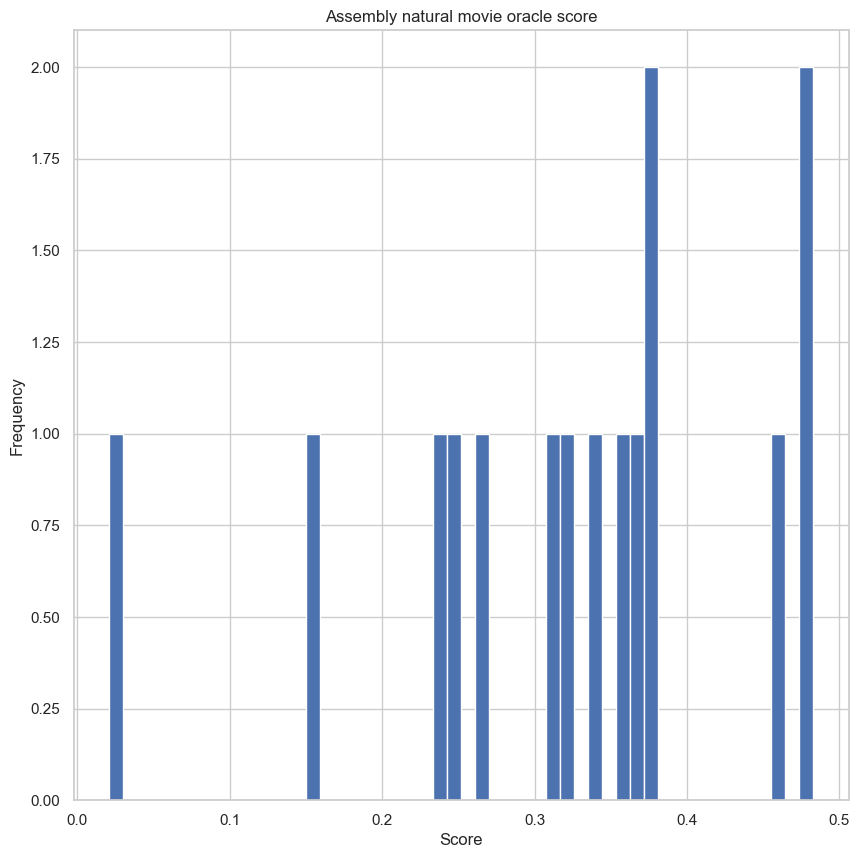

/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:112: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:119: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_timestamps = np.array(
/var/folders/37/xx86ns2176d3_9cr85gr_kch0000gn/T/ipykernel_71877/1007161748.py:121: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nm_data = np.array(presentation['natural_movie'].get('data'))


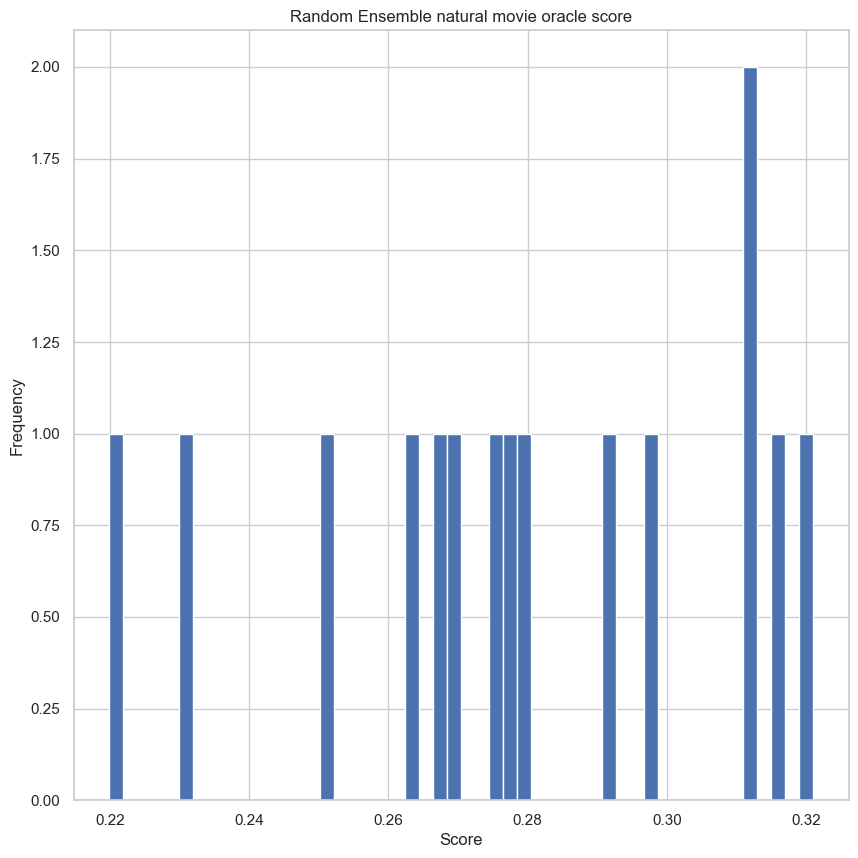

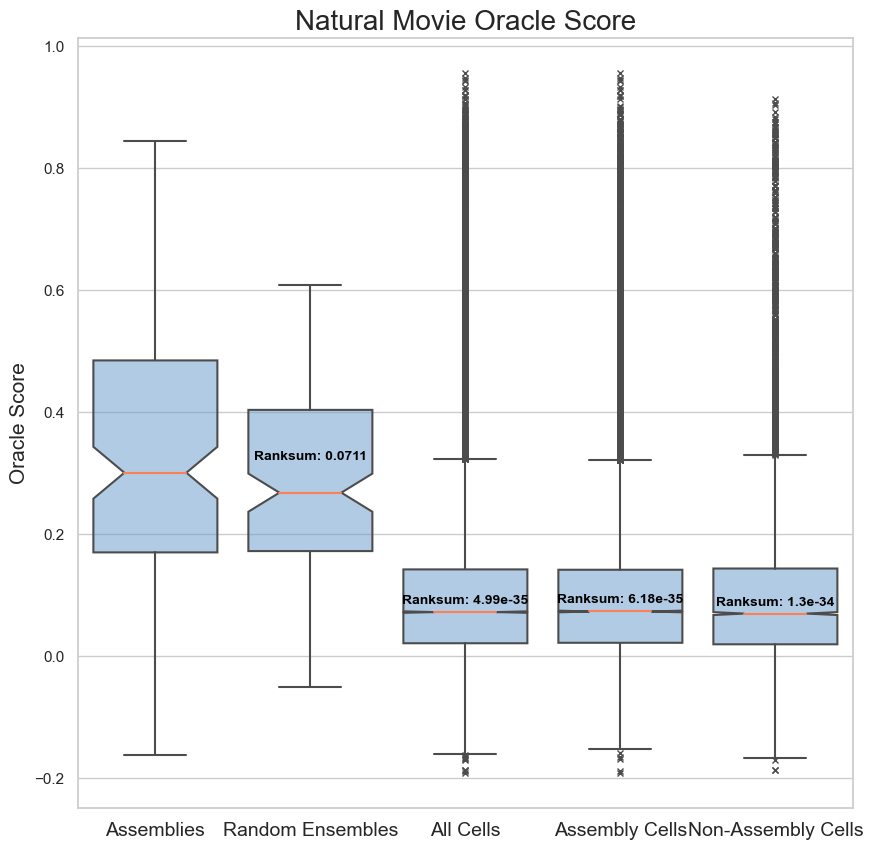

In [ ]:
pika_rois_all_dict = {}
pika_rois_in_assembly_dict = {}
pika_rois_no_assembly_dict = {}
for plane_n, roi_ns in rois_dict.items():
    pika_rois = []
    pika_rois_in_assembly = []
    pika_rois_no_assembly = []
    # print(plane_n)
    for roi_n in roi_ns:
        score = daf.get_pika_classifier_score(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n)
        if score > 0.5:  # Using the threshold from team PIKA, per https://github.com/zhuangjun1981/v1dd_physiology/blob/main/v1dd_physiology/example_notebooks/2022-06-27-data-fetching-basic.ipynb
            pika_rois.append(roi_n)
            if int(roi_n[4:]) in assembly_neurons:
                pika_rois_in_assembly.append(roi_n)
            else:
                pika_rois_no_assembly.append(roi_n)
    pika_rois_all_dict[plane_n] = pika_rois
    pika_rois_in_assembly_dict[plane_n] = pika_rois_in_assembly
    pika_rois_no_assembly_dict[plane_n] = pika_rois_no_assembly

total_rois = np.sum([len(val) for val in pika_rois_all_dict.values()])
neuron_all_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_in_assembly_dict.values()])
neuron_in_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

total_rois = np.sum([len(val) for val in pika_rois_no_assembly_dict.values()])
neuron_no_assembly_movie_oracle_r_values = np.zeros((total_rois, 9))

count_n_all = -1
count_n_in_assembly = -1
count_n_no_assembly = -1
for curr_dict, oracle_array, c in zip([pika_rois_all_dict, pika_rois_in_assembly_dict, pika_rois_no_assembly_dict], 
        [neuron_all_movie_oracle_r_values, neuron_in_assembly_movie_oracle_r_values, neuron_no_assembly_movie_oracle_r_values],
        [1,2,3]):
    for plane_n, pika_roi_ns in curr_dict.items():
        for roi_n in pika_roi_ns:
            if c == 1:
                count_n_all += 1
                current_count = count_n_all
            elif c == 2:
                count_n_in_assembly += 1
                current_count = count_n_in_assembly
            elif c == 3:
                count_n_no_assembly += 1
                current_count = count_n_no_assembly
            ### Get Time Trace
            dff, dff_ts = daf.get_single_trace(nwb_f=nwb_f, plane_n=plane_n, roi_n=roi_n, trace_type='dff')

            # Get Repeated Natural Movies
            trial_fluorescence = []
            presentation = nwb_f['stimulus']['presentation']
            nm_timestamps = np.array(
                presentation['natural_movie'].get('timestamps'))
            nm_data = np.array(presentation['natural_movie'].get('data'))
            new_clips = np.where(nm_data[:, 2] == 0)[0]
            clip_duration = 300  # new_clips[1]-1
            for repeat_id in range(new_clips.shape[0]):
                frames_to_capture = np.where(dff_ts >= nm_timestamps[new_clips[repeat_id]])[
                    0][0:clip_duration]
                trial_fluorescence.append(dff[frames_to_capture])
            trial_fluorescence_np = np.array(trial_fluorescence)
            for trial_idx in range(trial_fluorescence_np.shape[0]):
                removed_trial = trial_fluorescence_np[trial_idx]
                remaining_trials = np.delete(
                    trial_fluorescence_np, trial_idx, 0)
                r, p = scipy.stats.pearsonr(
                    removed_trial, np.mean(remaining_trials, 0))
                oracle_array[current_count, trial_idx] = r

assembly_movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = assembly_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        assembly_movie_oracle_r_values[roi_n, trial_idx] = r

# Plot Movie Oracles
mean_over_holdouts = np.mean(assembly_movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Assembly natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()

random_ensemble_movie_oracle_r_values = np.zeros((passing_roi_count, 9))
f = random_ensembles_coactivity_trace
# print(coactivity_trace)
f_ts = np.array(nwb_f['processing']['rois_and_traces_plane0']
                ['Fluorescence']['f_raw_subtracted'].get('timestamps'))
for roi_n in range(passing_roi_count):

    # Get Repeated Natural Movies
    trial_fluorescence = []
    presentation = nwb_f['stimulus']['presentation']
    nm_timestamps = np.array(
        presentation['natural_movie'].get('timestamps'))
    nm_data = np.array(presentation['natural_movie'].get('data'))
    new_clips = np.where(nm_data[:, 2] == 0)[0]
    clip_duration = 300  # new_clips[1]-1
    for repeat_id in range(new_clips.shape[0]):
        frames_to_capture = np.where(f_ts >= nm_timestamps[new_clips[repeat_id]])[
            0][0:clip_duration]
        trial_fluorescence.append(f[frames_to_capture, roi_n])
    trial_fluorescence_np = np.array(trial_fluorescence)
    for trial_idx in range(trial_fluorescence_np.shape[0]):
        removed_trial = trial_fluorescence_np[trial_idx]
        remaining_trials = np.delete(
            trial_fluorescence_np, trial_idx, 0)
        r, p = scipy.stats.pearsonr(
            removed_trial, np.mean(remaining_trials, 0))
        random_ensemble_movie_oracle_r_values[roi_n, trial_idx] = r

# Plot Movie Oracles
mean_over_holdouts = np.mean(random_ensemble_movie_oracle_r_values, 1)
fig = plt.figure()
plt.title('Random Ensemble natural movie oracle score')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.hist(mean_over_holdouts[:], bins=50)
#plt.savefig('oracle_dists2/assemblies_esteps_150000__affinity_04_session'+str(13)+'_movies.png')
plt.show()


all_arr = [np.array(assembly_movie_oracle_r_values).flatten(),
            np.array(random_ensemble_movie_oracle_r_values).flatten(),
            np.array(neuron_all_movie_oracle_r_values).flatten(),
            np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
            np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Assemblies", "Random Ensembles", "All Cells", "Assembly Cells", "Non-Assembly Cells"], size = 14)
ax.set_title('Natural Movie Oracle Score', size = 20)
ax.set_ylabel('Oracle Score', size = 15)

medians = np.array(
    [np.median(np.array(assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(random_ensemble_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
)

vertical_offset = medians * 0.2 # offset from median for display
p_values = [np.nan,
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(random_ensemble_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size='small', color='black', weight='semibold')

plt.savefig('oracle_scores_histogram_dff_all_sets.png', dpi = 1200)
plt.show()

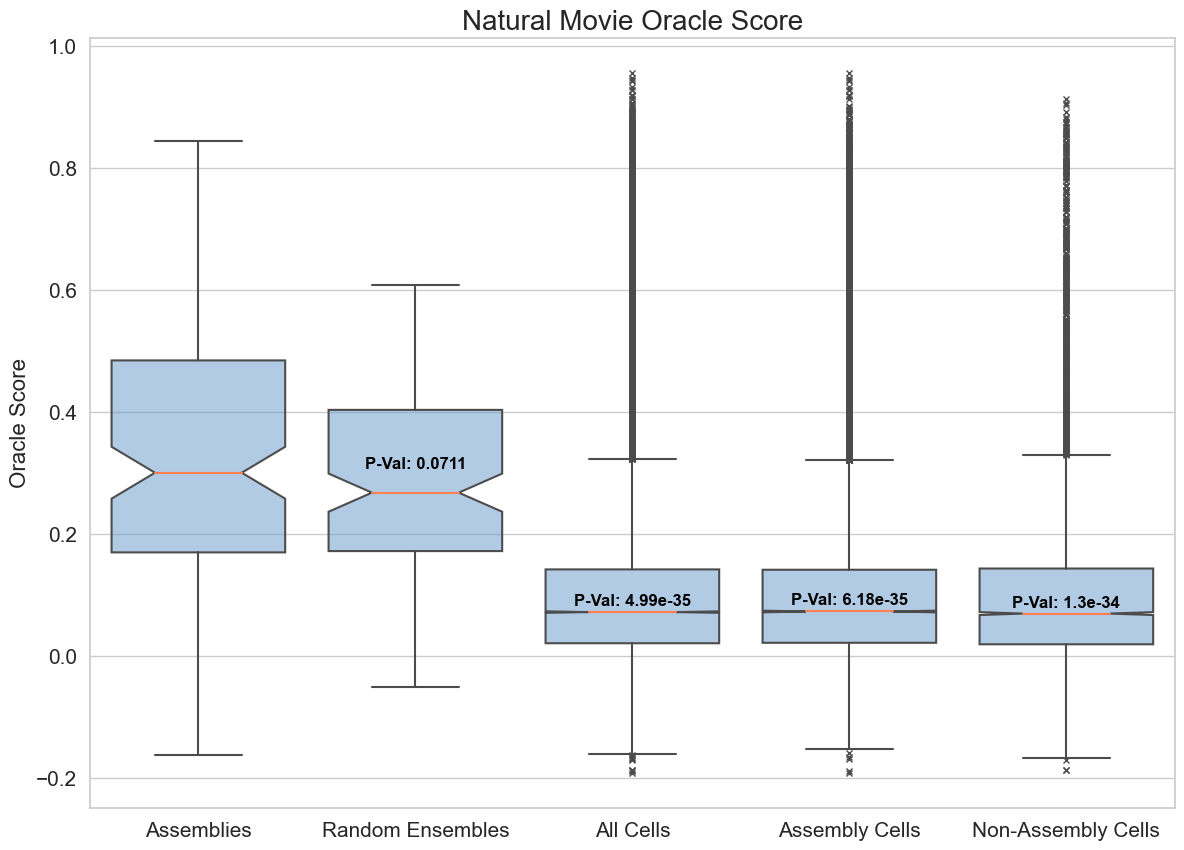

Rank-Sum (All Cells vs Assembly Cells): p_value = RanksumsResult(statistic=-0.6046686934717991, pvalue=0.545399153574734)
Rank-Sum (All Cells vs Non-Assembly Cells): p_value = RanksumsResult(statistic=1.1551444949164207, pvalue=0.2480312598768294)
Rank-Sum (Assembly Cells vs Non-Assembly Cells): p_value = RanksumsResult(statistic=1.5259467532683355, pvalue=0.12702312576412797)


In [ ]:
# Plot Movie Oracles
plt.figure(figsize=(14, 10))

all_arr = [np.array(assembly_movie_oracle_r_values).flatten(),
            np.array(random_ensemble_movie_oracle_r_values).flatten(),
            np.array(neuron_all_movie_oracle_r_values).flatten(),
            np.array(neuron_in_assembly_movie_oracle_r_values).flatten(),
            np.array(neuron_no_assembly_movie_oracle_r_values).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Assemblies", "Random Ensembles", "All Cells", "Assembly Cells", "Non-Assembly Cells"], size = 15)
ax.set_title('Natural Movie Oracle Score', size = 20)
ax.set_ylabel('Oracle Score', size = 16)
plt.yticks(fontsize=15)

medians = np.array(
    [np.median(np.array(assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(random_ensemble_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_all_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_in_assembly_movie_oracle_r_values).flatten()),
     np.median(np.array(neuron_no_assembly_movie_oracle_r_values).flatten())]
)

vertical_offset = medians * 0.15 # offset from median for display
p_values = [np.nan,
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(random_ensemble_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_all_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5),
            'P-Val: {:.3g}'.format(stats.ranksums(np.array(assembly_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten(), alternative = 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size= 12, color='black', weight='semibold')

plt.savefig('oracle_scores_histogram_dff_all_sets.png', dpi = 1200)
plt.show()

wrs_p_value = stats.ranksums(np.array(neuron_all_movie_oracle_r_values).flatten(), np.array(neuron_in_assembly_movie_oracle_r_values).flatten())
print(f"Rank-Sum (All Cells vs Assembly Cells): p_value = {wrs_p_value}")
wrs_p_value = stats.ranksums(np.array(neuron_all_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten())
print(f"Rank-Sum (All Cells vs Non-Assembly Cells): p_value = {wrs_p_value}")
wrs_p_value = stats.ranksums(np.array(neuron_in_assembly_movie_oracle_r_values).flatten(), np.array(neuron_no_assembly_movie_oracle_r_values).flatten())
print(f"Rank-Sum (Assembly Cells vs Non-Assembly Cells): p_value = {wrs_p_value}")

### Reproduce Sparsity Plot with Random Ensembles

In [ ]:
def plot_ginis(coactivity_trace, null_trace=None, all_trace=None, a_trace=None, no_a_trace=None):
    num_assemblies = coactivity_trace.shape[1]
    gini_values = [gini(coactivity_trace[:,i]) for i in range(num_assemblies)]
    labels = [f'A {i+1}' for i in range(num_assemblies)]
    if no_a_trace is not None:
        gini_vaulues_no_a =[gini(no_a_trace[:,i]) for i in range(no_a_trace.shape[1])]
        mean_gini_no_a = np.mean(gini_vaulues_no_a)
        gini_values.insert(0, mean_gini_no_a)
        labels.insert(0, 'Nonassembly\nCells')
    if a_trace is not None:
        gini_vaulues_a =[gini(a_trace[:,i]) for i in range(a_trace.shape[1])]
        mean_gini_a = np.mean(gini_vaulues_a)
        gini_values.insert(0, mean_gini_a)
        labels.insert(0, 'Assembly\nCells')
    if all_trace is not None:
        gini_vaulues_all =[gini(all_trace[:,i]) for i in range(all_trace.shape[1])]
        mean_gini_all = np.mean(gini_vaulues_all)
        gini_values.insert(0, mean_gini_all)
        labels.insert(0, 'All\nCells')
    if null_trace is not None:
        gini_values_null = [gini(null_trace[:,i]) for i in range(num_assemblies)]
        mean_gini_null = np.mean(gini_values_null)
        gini_values.insert(0, mean_gini_null)
        labels.insert(0, 'Null')

    # Create a base bar plot
    plt.figure()
    ax = sns.barplot(x=np.arange(len(gini_values)), y=gini_values, color= (.4, .6, .8, .5))
    ax.set_title('Sparsity of Assembly Co-Activity', size = 20)
    ax.set_xticklabels(labels)
    plt.yticks(fontsize = 15)
    plt.xticks(fontsize = 15, rotation = 45)
    ax.set_ylabel('Gini Coefficient', size = 18)
    ax.set_xlabel('Population Grouping', size = 18)
    plt.ylim((0,1.0))

    # Remove chartjunk (redundant elements)
    # plt.tick_params(axis='both', which='both', length=0)  # Hide ticks
    # plt.gca().spines['top'].set_visible(False)            # Hide top spine
    # plt.gca().spines['right'].set_visible(False)          # Hide right spine
    
    # Add annotations for clarity (optional)
    for i, value in enumerate(gini_values):
        plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    plt.savefig('sparsity_with_Gini_coefficient_by_assembly.png')
    # if null_trace is not None:
    #     # Create a base bar plot
    #     plt.figure()
    #     plt.bar(x=np.arange(len(gini_values_null)), height=gini_values_null, tick_label=labels)
    #     plt.ylim((0,1.0))
    #     # Apply Labels:
    #     plt.title("Assembly Sparsity")            # Add a title
    #     plt.xlabel("Assemblies")                 # Label the x-axis
    #     plt.ylabel("Gini Coefficient")                     # Label the y-axis
    #     # Remove chartjunk (redundant elements)
    #     plt.tick_params(axis='both', which='both', length=0)  # Hide ticks
    #     plt.gca().spines['top'].set_visible(False)            # Hide top spine
    #     plt.gca().spines['right'].set_visible(False)          # Hide right spine
    #     # Add annotations for clarity (optional)
    #     for i, value in enumerate(gini_values_null):
    #         plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')
    #     plt.savefig('sparsity_with_Gini_coefficient_by_random_ensemble.png')

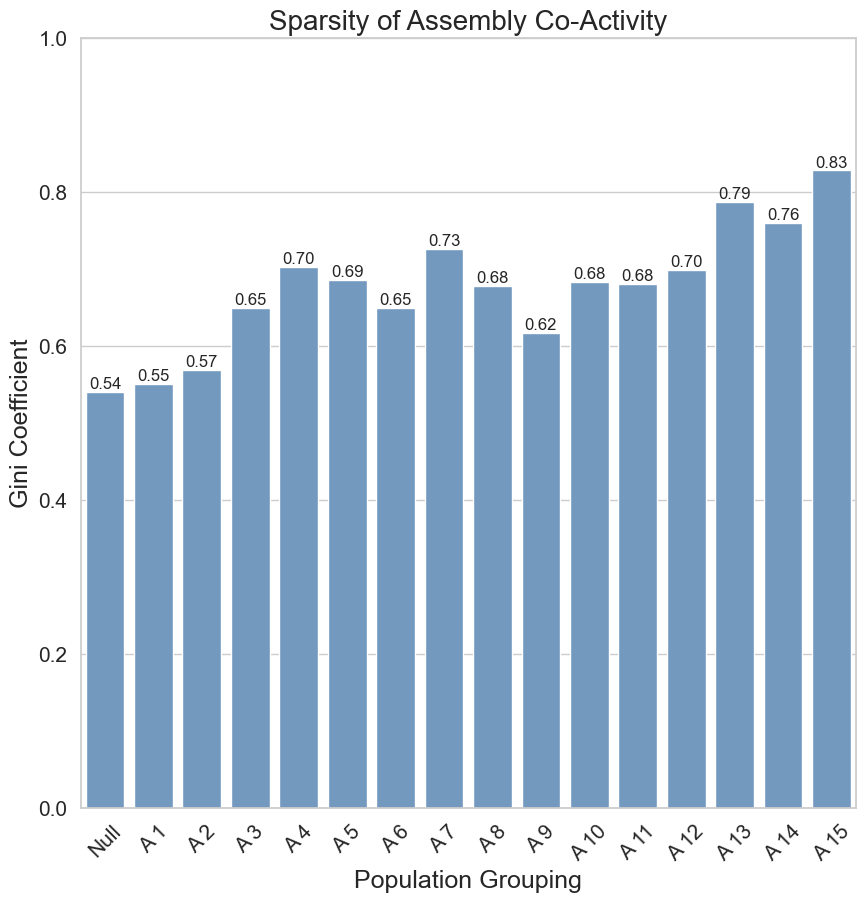

In [ ]:
plot_ginis(assembly_coactivity_trace, random_ensembles_coactivity_trace)